# **Intro**
In this notebook I set up semi-supervised VAE that disentangles the rotation and digits of MNIST numbers. 
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: cell-type proportions, sample_id, and everything else (slack).
In this experiment, there is a cell-type specific drug-perturbation for some of the samples.
In particular, cell-type 6 has a different expression profile for samples 0, 5, 6, 7.
Additionally, these samples do not have ground-truth cell-type proportions.
This is analogous to the problem of trying to find cell-type specific perturbation effects from bulk RNA-Seq data.
We see that cell-type 6 looks different in the slack when comparing perturbed to non-perturbed samples.

This is acheived through disentangling a majority of the cell-type and sample-type variation. 
To enforce this disentanglement, there are two different encoders with different losses.
Sample-classification loss is on one set of latent codes.
Proportion-estimation loss is on another set of latent codes.
No loss is applied to the slack latent codes.
The embeddings are then concatenated together and used as input to a joint decoder.

Proportion estimation is done in a semi-supervised way (borrowing heavily from saemundsson and bjlkeng).
When the proportions are available, we directly input them into the decoder and simultaneously train the auxilliary proportion-estimator.
When they are unavailable, we use the output of the auxilliary proportion-estimator as the input to the proportion-decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.


The experimental set-up is as follows:
The sample 0, 5, 6, 7 are perturbed. 
This means that cell-typ 6 has a different gene-expression profile for those samples.
Samples 1 and 2 have ground truth cell-type proportions (single-cell generated pseudobulks).
Samples 0, 3-9 do not have ground truth cell-type proportions, which is a stand in for real bulk data.
However, since this is a simulation it is actually generated from single-cell pseudobulks, we just dont look at the proportions.

We show that our latent representations of cell-type and sample are disentangled.
We show that we are able to manipulate the latent space in order to simulate specific cells or samples.
We show that the slack is able to find cell-type specific effects -- **even when the effect is only observed in bulk**

This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


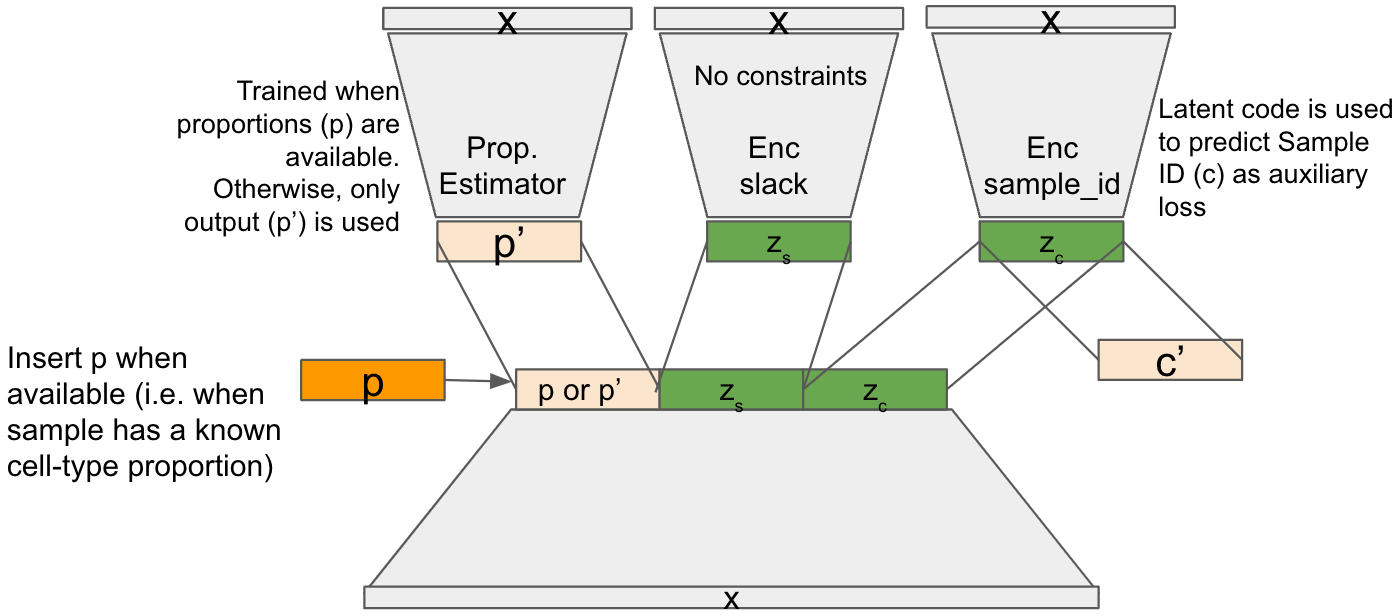

# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt"

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job18_Results.csv"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

num_genes = 7000

exp_id = "cd4Naive-kang"

# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 10

# number of patients/domains/samples expected
idx_range = range(0, 16)
n_tot_samples = 8 # 8 patients, 2 samples each

# number of drugs (one-hot encoded)
n_drugs = 2

# experiment id
lab_file_name = exp_id

# number of pseudobulks PER patient
n_train = 1000



### create the domains label 
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 2),
                            np.full(n_train, 3), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 4),
                            np.full(n_train, 5), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 6),
                            np.full(n_train, 7), np.full(n_train, 7)], axis=0)
label_full = to_categorical(Label_full)

### create the drugs label 
Drug_full = np.concatenate([np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0)], axis=0)
drug_full = to_categorical(Drug_full)


# indexes for the training
# 0, 1 no drug is labeled 
# 0,3-9 is unlabeled

idx_train = np.where(np.logical_and(Label_full < 2, Drug_full == 0))[0] 
idx_unlab = np.where(Label_full >= 2)[0]
idx_drug = np.where(Drug_full > 0)[0]

idx_bulk =  np.where(Label_full >= 2)[0]

In [4]:
idx_bulk.shape

(12000,)

# **Load / Pre-process data**
Import pre-processed pseudobulks

In [5]:

##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_train, Y_train, gene_df = sc_preprocess.read_all_diva_files(aug_data_path, idx_range, lab_file_name)
X_train.columns = gene_df


# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train = X_train[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_full = X_train.to_numpy()
Y_full = Y_train.to_numpy()

## get the top variable genes
X_colmean = X_full.mean(axis=0)
X_colvar = X_full.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
gene_df = gene_df.iloc[idx_top]


In [6]:
np.sort(X_colmean)

array([0.0, 0.0, 0.0, ..., 504776.8421875, 512199.240625, 975718.2125],
      dtype=object)

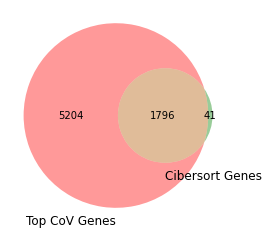

In [7]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [8]:
union_genes = np.union1d(gene_df, cibersort_genes)


In [9]:
def pearsonr_2D(x, y):
    """computes pearson correlation coefficient
       where x is a 1D and y a 2D array"""

    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    
    rho = upper / lower
    
    return rho

In [10]:
X_full = X_train.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)
X_full = scaler.transform(X_full)

X_orig = np.copy(X_full)

# get the bulks that are similar to each other
# for each bulk sample
for curr_bulk_idx in range(2,8):
    for perturb_bulk_idx in range(0,2):

        temp_idx_bulk =  np.where(np.logical_and(Label_full == curr_bulk_idx, Drug_full == perturb_bulk_idx))[0]
        if temp_idx_bulk.shape[0] == 0:
            continue

        orig_Y_bulk = np.transpose(Y_full[temp_idx_bulk[0],])
        corr_orig = pearsonr_2D(orig_Y_bulk.astype(float), Y_full[temp_idx_bulk,].astype(float))
        top_corr_idx = np.where(corr_orig > 0.8)[0][0:10]

        # if the Y isn't highly correlated to get enough replicates
        # go to the next one
        corr_bulk_idx = 1
        while top_corr_idx.shape[0] < 10:
            orig_Y_bulk = np.transpose(Y_full[temp_idx_bulk[corr_bulk_idx],])
            corr_orig = pearsonr_2D(orig_Y_bulk.astype(float), Y_full[temp_idx_bulk,].astype(float))
            top_corr_idx = np.where(corr_orig > 0.8)[0][0:10]
            corr_bulk_idx = corr_bulk_idx + 1

        # replace the temp_idx_bulk
        X_temp = np.copy(X_full[temp_idx_bulk,])
        X_temp = X_temp[top_corr_idx,]
        X_temp = np.tile(X_temp, (100, 1))
        X_full[temp_idx_bulk,] = X_temp

        Y_temp = np.copy(Y_full[temp_idx_bulk,])
        Y_temp = Y_temp[top_corr_idx,]
        Y_temp = np.tile(Y_temp, (100, 1))
        Y_full[temp_idx_bulk,] = Y_temp

# for unknown proportions; i.e. 3 
X_unkp = X_full[idx_unlab,]
label_unkp = label_full[idx_unlab,]
drug_unkp = drug_full[idx_unlab,]
y_unkp = Y_full[idx_unlab,]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
drug_kp = drug_full[idx_train,]
y_kp = Y_full[idx_train,]



In [11]:
X_train

gene_ids LINC00115 NOC2L KLHL17 PLEKHN1 HES4 ISG15 AGRN C1orf159 TNFRSF18  \
0              120   550      0       0   68   767    1       36      528   
0              171   316      0       0    9   388    0       64      625   
0              189   631      0      80   13   905    1       66     1468   
0              104   525      0      33   14   455    1       24     2259   
0               61   358     29       0    6   350    0       23     4729   
..             ...   ...    ...     ...  ...   ...  ...      ...      ...   
0                3   205      0       0  164  1823   64        4     1223   
0                7   271      0      10   39   637    0        5      273   
0                2   271      0       0  146  1032    0        2     1289   
0                1   238      0       0    3  2132   10        2     4346   
0                0   194      0       0   44  1045   34        0      413   

gene_ids TNFRSF4  ... CPT1B AF127936.5 AJ006998.2 CHODL AP000476.1 LINC00158  \
0            354  ...     0          0          0     0          0         0   
0            396  ...     0          0          0     0          0         0   
0           1287  ...     0          0          0     0          0         0   
0            488  ...     0          0          0     0          0         0   
0            372  ...     0          0          0     0          0         0   
..           ...  ...   ...        ...        ...   ...        ...       ...   
0            676  ...     0          0          0     0          0         0   
0             51  ...     0          0          0     0          0         0   
0            324  ...     0          0          0     0          0         0   
0           1060  ...     0          0          0     0          0         0   
0            295  ...     0          0          0     0          0         0   

gene_ids AF131217.1 AP001437.1 TMPRSS3 LRRC3DN  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
..              ...        ...     ...     ...  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  

[16000 rows x 13452 columns]

In [12]:
X_ids_temp = X_train.loc[:,union_genes]
X_ids_temp

gene_ids  A2M AACS AAED1 AAGAB  AAMP AAR2 AARS2 AASDHPPT  AATF AATK  ...  \
0           0   14   281   120   510   86     0     1776  1269    0  ...   
0           2    8   179   117   532  104     3      958  2260  231  ...   
0         114   47   141    71   557  143     3     1205  2868  141  ...   
0          75   31   101    41   337  114     5      932  1812   18  ...   
0           0   44   103    67   329  109    15      604  1729   91  ...   
..        ...  ...   ...   ...   ...  ...   ...      ...   ...  ...  ...   
0         122    0   286   156  5208  133     0       56  1662    0  ...   
0           9    0   119    29  4378    5     0      169   854    0  ...   
0          15    0   124   176  4784   90     0      134  1069    0  ...   
0           0    0   158   652  9728  332     0       10   113    0  ...   
0          79    0   130    21  3558   28     0      103   994    0  ...   

gene_ids ZSCAN18 ZSCAN25 ZSWIM4 ZSWIM7 ZWINT ZXDA ZXDC ZYG11B  ZYX ZZEF1  
0           1079       5      0   1355   506    0   22      4  446     1  
0            362       3    126    955   213    0   63      2  465     1  
0            634      12     94   1344   281    5   77      0  542     1  
0            908      12     29    971   646    1    8      2  303     0  
0            879       1     38   1490    91    0   31      0  317     1  
..           ...     ...    ...    ...   ...  ...  ...    ...  ...   ...  
0             10       1   1274     39     0   21    3      2  267  1439  
0              0       0    513     31     0    0    2      0  267   392  
0             13       3    224    146     0    7  135      0  111   339  
0              0       0      5      4     0    3    0      0   46    40  
0              2       1   1371     40     0   12   89      0   96  1339  

[16000 rows x 7041 columns]

In [13]:
Y_full[np.where(np.logical_and(Label_full == 6, Drug_full == 1))[0][1:22],]

array([[0.0048, 0.6188, 0.0026, 0.2914, 0.0412, 0.022, 0.0012, 0.0054,
        0.0026, 0.01],
       [0.0032, 0.7206, 0.0838, 0.1098, 0.0092, 0.002, 0.005, 0.037,
        0.0004, 0.029],
       [0.094, 0.4574, 0.0802, 0.0504, 0.0016, 0.017, 0.0044, 0.0012,
        0.2384, 0.0554],
       [0.0232, 0.4932, 0.1124, 0.0054, 0.0212, 0.0496, 0.069, 0.003,
        0.2178, 0.0052],
       [0.0314, 0.5182, 0.1504, 0.0046, 0.0112, 0.0988, 0.0262, 0.035,
        0.0446, 0.0796],
       [0.0054, 0.673, 0.0026, 0.114, 0.0326, 0.0128, 0.0392, 0.0516,
        0.064, 0.0048],
       [0.1364, 0.6504, 0.0226, 0.0148, 0.0026, 0.0074, 0.0038, 0.0524,
        0.0032, 0.1064],
       [0.0086, 0.7394, 0.126, 0.0284, 0.0104, 0.003, 0.02, 0.0034,
        0.011, 0.0498],
       [0.0244, 0.7012, 0.0956, 0.007, 0.0096, 0.0532, 0.0088, 0.0268,
        0.0228, 0.0506],
       [0.0008, 0.8864, 0.0092, 0.0114, 0.0006, 0.0094, 0.0184, 0.0046,
        0.0, 0.0592],
       [0.0048, 0.6188, 0.0026, 0.2914, 0.0412, 0.022,

In [14]:
Y_train

B CD4_Mem_T CD4_Naive_T   CD8_T CD14_Mono CD16_Mono      DC      Mk  \
0    0.002    0.0012      0.0124   0.034     0.002    0.3536  0.0004  0.0002   
0   0.0532      0.08      0.0012  0.2458     0.152    0.0008  0.0108  0.4094   
0   0.0288    0.1572      0.0996  0.1236    0.0086      0.02  0.1828   0.242   
0   0.0424    0.0208      0.0652  0.5014    0.0196    0.0012  0.1304  0.0296   
0   0.1594     0.043      0.0012   0.078     0.091     0.054  0.0038  0.0856   
..     ...       ...         ...     ...       ...       ...     ...     ...   
0    0.209    0.1964       0.024  0.1452    0.0036    0.1884  0.0106   0.006   
0   0.6482    0.0086      0.0014  0.0342      0.03     0.172  0.0494   0.002   
0   0.8132     0.047      0.0276  0.0394    0.0286    0.0052  0.0022  0.0008   
0   0.2352     0.206       0.013  0.0508    0.0616    0.1812  0.0066   0.021   
0    0.664    0.0142      0.0244  0.0106     0.082    0.1118  0.0146  0.0158   

        NK   T_Act  
0   0.0014  0.5928  
0    0.006  0.0408  
0     0.09  0.0474  
0   0.1276  0.0618  
0   0.4624  0.0216  
..     ...     ...  
0   0.0632  0.1536  
0   0.0156  0.0386  
0   0.0048  0.0312  
0   0.0128  0.2118  
0   0.0096   0.053  

[16000 rows x 10 columns]

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16000 samples in 0.094s...
[t-SNE] Computed neighbors for 16000 samples in 20.185s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16000
[t-SNE] Computed conditional probabilities for sample 2000 / 16000
[t-SNE] Computed conditional probabilities for sample 3000 / 16000
[t-SNE] Computed conditional probabilities for sample 4000 / 16000
[t-SNE] Computed conditional probabilities for sample 5000 / 16000
[t-SNE] Computed conditional probabilities for sample 6000 / 16000
[t-SNE] Computed conditional probabilities for sample 7000 / 16000
[t-SNE] Computed conditional probabilities for sample 8000 / 16000
[t-SNE] Computed conditional probabilities for sample 9000 / 16000
[t-SNE] Computed conditional probabilities for sample 10000 / 16000
[t-SNE] Computed conditional probabilities for sample 11000 / 16000
[t-SNE] Computed conditional probabilities for sample 12000 / 16000
[t-SNE] Computed conditional probabilities for s

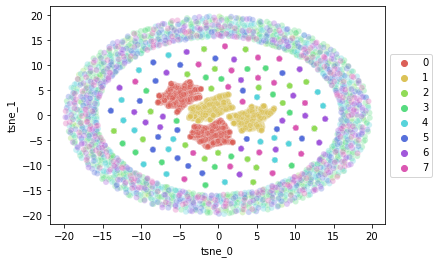

In [15]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [16]:
idx_9 = np.where(Label_full == 9)[0]
true_9_prop_df = Y_train.iloc[idx_9]
X_unkp_9 = X_full[idx_9,]


# **M2 Model Definition**

## Hyperparameters

In [116]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 100 # 500 

alpha_rot = 1000000 #1000000
alpha_drug = 10000 #1000000
alpha_prop = 100 #100

beta_kl_slack = 0.1 # 10 ###
beta_kl_rot = 100 # 100 ###
beta_kl_drug = 100 # 100 ###


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 8 donors 
n_drugs = n_drugs  # number of drugs one-hot encoded
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer 512 
decoder_dim = 512 # dim of encoder hidden layer 512 
decoder_out_dim = n_x # dim of decoder output layer

# labeled classifier
class_dim1 = 512 # 512 
class_dim2 = 256 # 256 


activ = 'relu'
optim = Adam(learning_rate=0.0005) #0.001
print(f"length of X {n_x} and length of y {n_y} n_label {n_label} and n_drugs {n_drugs}")



length of X 7041 and length of y 10 n_label 8 and n_drugs 2


## Encoder + Y classifier

In [117]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
Y = Input(shape=(n_y,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))
z_in = Input(shape=(n_y+n_label_z+n_label_z+n_label_z,))
cls_in = Input(shape=(n_label_z,))

inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(inputs)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(inputs)
encoder_d = Dense(encoder_dim, activation=activ, name="encoder_drug")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_label_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_label_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)


mu_drug = Dense(n_label_z, activation='linear', name = "mu_drug")(encoder_d)
l_sigma_drug = Dense(n_label_z, activation='linear', name = "sigma_drug")(encoder_d)



# set up labeled classifier
#defining the architecture of the classifier

class_hidden1 = Dense(class_dim1, activation=activ, name = "cls_h1")
class_hidden2 = Dense(class_dim2, activation=activ, name="cls_h2")
class_out = Dense(n_y, activation='softmax', name="cls_out")

#x_concat_lab = tf.keras.layers.concatenate([inputs, label])
#classifier_h1 = class_hidden1(tf.keras.layers.Concatenate()([inputs, label]))
classifier_h1 = class_hidden1(inputs)
classifier_h2 = class_hidden2(classifier_h1)
Y_cls = class_out(classifier_h2)



## Latent Space

In [118]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_label_z])
z_rot = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])
z_drug = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_drug")([mu_drug, l_sigma_drug, n_label_z])

z_concat_lab = concat([z_slack, Y, z_rot, z_drug])
z_concat_unlab = concat([z_slack, Y_cls, z_rot, z_drug])

## Decoder + Classifiers

In [119]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

d_in = Input(shape=(n_label_z+n_y+n_label_z+n_label_z,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)

# set up the decoder part that links to the encoder
# labeled decoder
h_lab = decoder_hidden(z_concat_lab)
outputs_lab = decoder_out(h_lab)

# unlabeled decoder
h_unlab = decoder_hidden(z_concat_unlab)
outputs_unlab = decoder_out(h_unlab)


###### Rotations classifier
# this is the rotation we try to estimate
rot_h1 = ReLU(name = "rot_h1")
rot_h2 = Dense(n_label, activation='linear', name = "rot_h2")
rot_softmax = Softmax(name = "mu_rot_pred")
decoder_sigma_r = Lambda(null_f, name = "l_sigma_rot_pred")


rot_1_out = rot_h1(z_rot)
rot_2_out = rot_h2(rot_1_out)
rotation_outputs = rot_softmax(rot_2_out)
sigma_outputs_r = decoder_sigma_r(l_sigma_rot)



###### Drug classifier
# this is the drug we try to estimate
drug_h1 = ReLU(name = "drug_h1")
drug_h2 = Dense(n_drugs, activation='linear', name = "drug_h2")
drug_softmax = Softmax(name = "mu_drug_pred")
decoder_sigma_d = Lambda(null_f, name = "l_sigma_drug_pred")


drug_1_out = drug_h1(z_drug)
drug_2_out = drug_h2(drug_1_out)
drug_outputs = drug_softmax(drug_2_out)
sigma_outputs_d = decoder_sigma_d(l_sigma_drug)








## Loss

In [120]:

def vae_loss(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_drug = beta_kl_drug * K.sum(K.exp(l_sigma_drug) + K.square(mu_drug) - 1. - l_sigma_drug, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_rot +kl_drug+ kl_slack


def recon_loss(y_true, y_pred):
	return K.sum(mean_squared_error(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_prop

def drug_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_drug


def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)*alpha_rot
    return recon



## Make the computational graph

In [121]:
classifier = Model(X, Y_cls)

known_prop_vae = Model([X, Y], [outputs_lab, Y_cls, rotation_outputs, drug_outputs])
unknown_prop_vae = Model(X, [outputs_unlab, rotation_outputs, drug_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, drug_loss]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, class_loss, drug_loss]) #, metrics = [KL_loss, recon_loss])

encoder_unlab = Model(X, [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug])

encoder_lab = Model([X, Y], [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug])


decoder = Model(d_in, d_out)


print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 7041)]       0                                            
__________________________________________________________________________________________________
encoder_slack (Dense)           (None, 512)          3605504     input_8[0][0]                    
__________________________________________________________________________________________________
encoder_rot (Dense)             (None, 512)          3605504     input_8[0][0]                    
__________________________________________________________________________________________________
encoder_drug (Dense)            (None, 512)          3605504     input_8[0][0]                    
____________________________________________________________________________________________

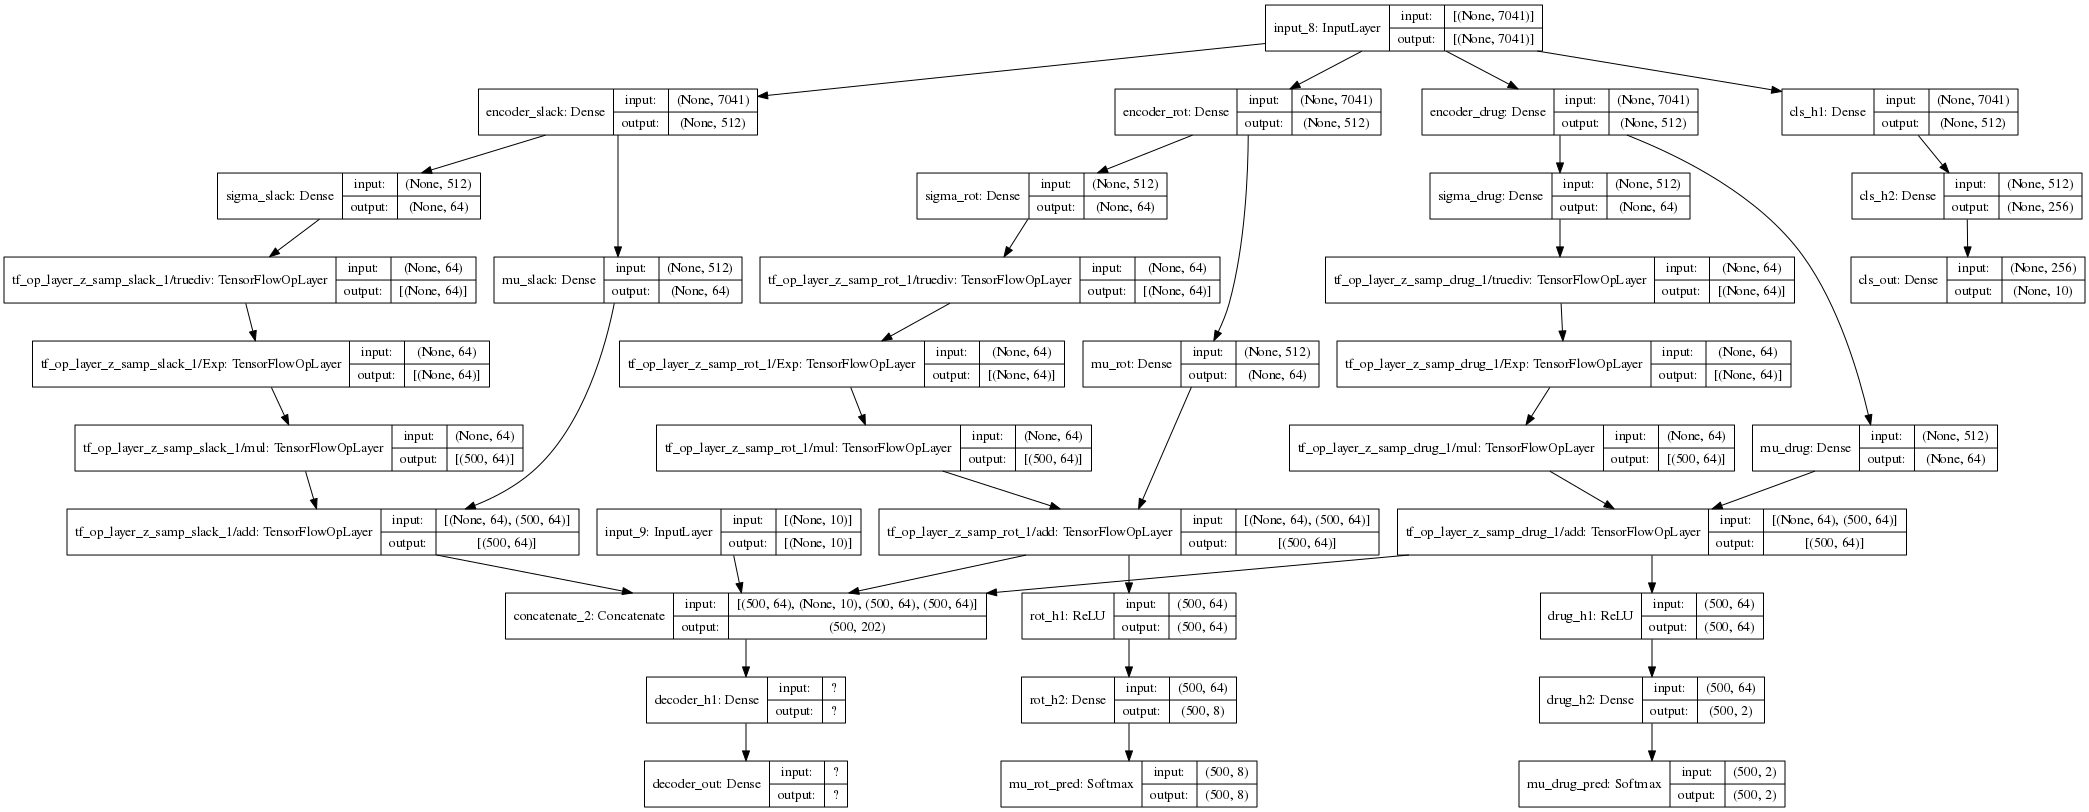

In [122]:
display(plot_model(known_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

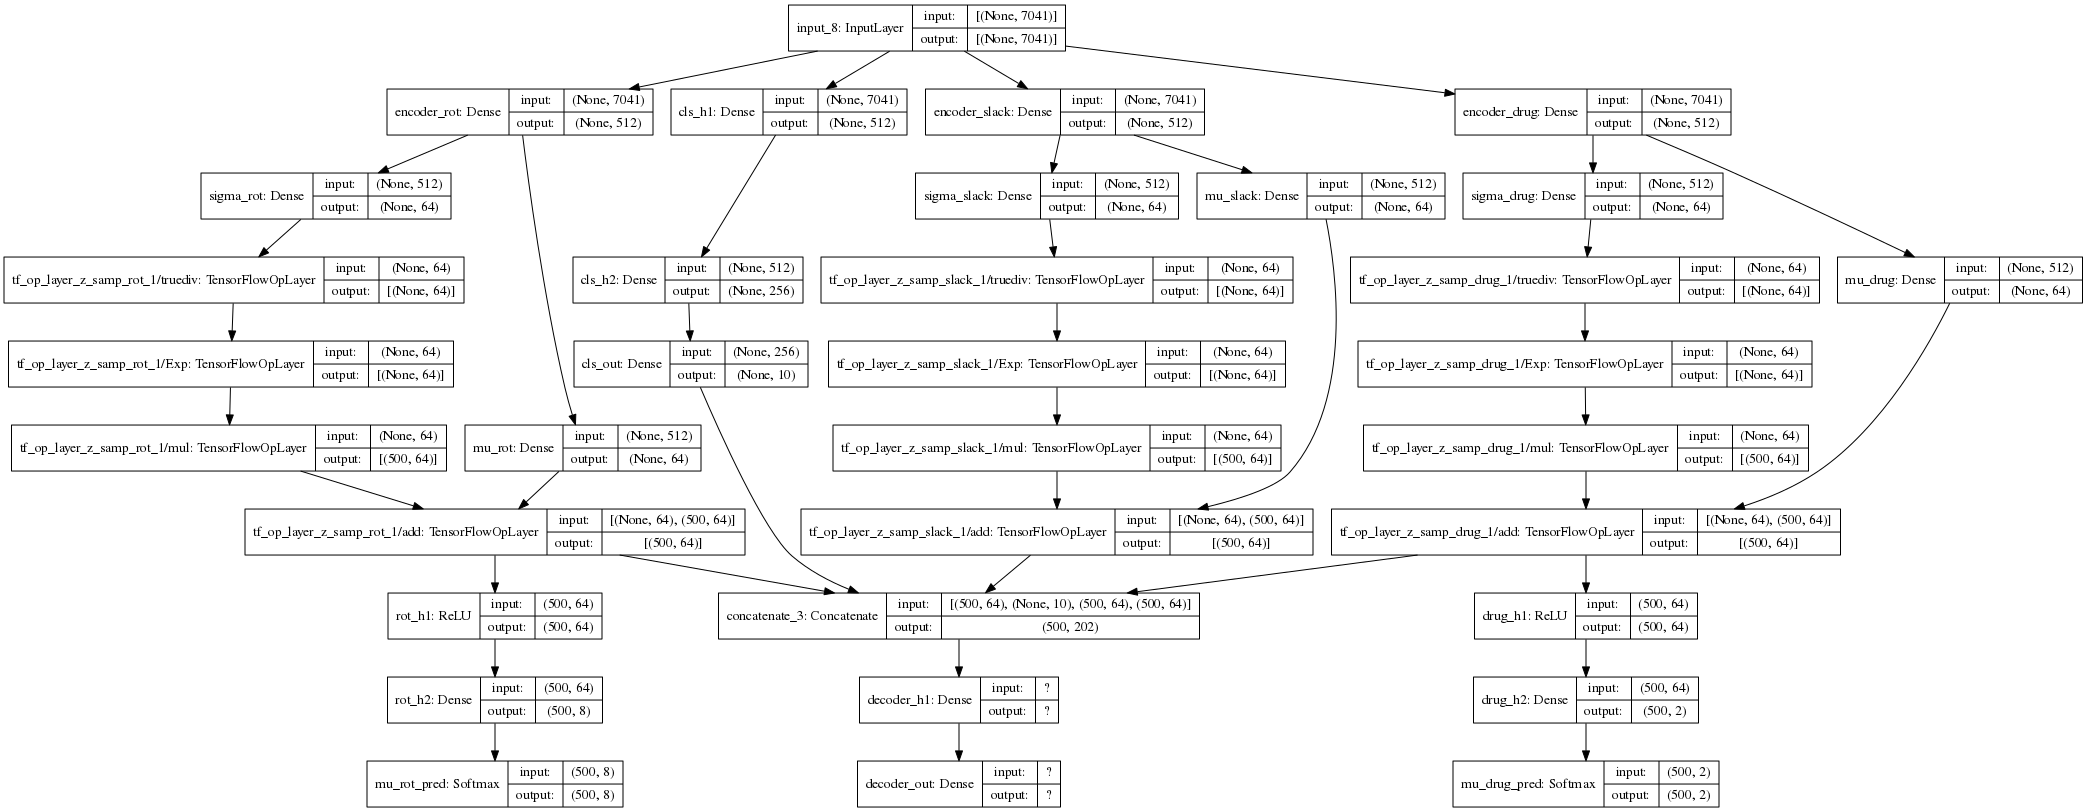

In [123]:
display(plot_model(unknown_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [124]:


def fit_model(X_unknown_prop, label_unknown_prop, drug_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, drug_known_prop, epochs):
    assert len(X_unknown_prop) % len(X_known_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    meta_hist = []
    
    for epoch in range(epochs):
        unlabeled_index = np.arange(len(X_unknown_prop))
        np.random.shuffle(unlabeled_index)

        # Repeat the unlabeled data to match length of labeled data
        labeled_index = []
        for i in range(len(X_unknown_prop) // len(X_known_prop)):
            l = np.arange(len(X_known_prop))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        for i in range(batches):
            # Labeled
            index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
            loss = known_prop_vae.train_on_batch([X_known_prop[index_range], Y_known_prop[index_range]],
                                                    [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range], drug_known_prop[index_range]])
            meta_hist.append(i)

            # Unlabeled
            index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
            loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range],
                                                        [X_unknown_prop[index_range], label_unknown_prop[index_range], drug_unknown_prop[index_range]])]

            meta_hist.append(i)

            history.append(loss)
            
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return [history, meta_hist]

In [125]:
for layer in classifier.layers:
    print(layer)

In [126]:
for layer in encoder_unlab.layers:
    print(layer.name)

input_8
encoder_slack
encoder_rot
encoder_drug
sigma_slack
sigma_rot
sigma_drug
tf_op_layer_z_samp_slack_1/truediv
tf_op_layer_z_samp_rot_1/truediv
tf_op_layer_z_samp_drug_1/truediv
tf_op_layer_z_samp_slack_1/Exp
tf_op_layer_z_samp_rot_1/Exp
tf_op_layer_z_samp_drug_1/Exp
mu_slack
tf_op_layer_z_samp_slack_1/mul
mu_rot
tf_op_layer_z_samp_rot_1/mul
mu_drug
tf_op_layer_z_samp_drug_1/mul
tf_op_layer_z_samp_slack_1/add
tf_op_layer_z_samp_rot_1/add
tf_op_layer_z_samp_drug_1/add


Now train

In [127]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


In [128]:
# X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop
loss_history = fit_model(X_unkp,
                    label_unkp,
                    drug_unkp,
                    X_kp, 
                    y_kp,
                    label_kp, 
                    drug_kp, epochs=n_epoch)



Elapsed:  1022.1882293224335


In [129]:
meta_history = loss_history[1]
loss_history = loss_history[0]

# Plot Loss Curves

In [130]:
# write out the loss for later plotting
# unpack the loss values
labeled_total_loss = [item[0] for item in loss_history]
unlabeled_total_loss = [item[5][0] for item in loss_history]

labeled_recon_loss = [item[1] for item in loss_history]
unlabeled_recon_loss = [item[5][1] for item in loss_history]

labeled_prop_loss = [item[2] for item in loss_history]

labeled_samp_loss = [item[3] for item in loss_history]
unlabeled_samp_loss = [item[5][2] for item in loss_history]

labeled_drug_loss = [item[4] for item in loss_history]
unlabeled_drug_loss = [item[5][2] for item in loss_history]


# make into a dataframe
total_loss = labeled_total_loss + unlabeled_total_loss + [a + b for a, b in zip(labeled_total_loss, unlabeled_total_loss)]
loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
loss_df['type'] = ["labeled"]*len(loss_history) + ["unlabeled"]*len(loss_history) + ["sum"]*len(loss_history)
loss_df['batch'] = [*range(len(loss_history))] + [*range(len(loss_history))] + [*range(len(loss_history))]

recon_loss = labeled_recon_loss + unlabeled_recon_loss + [a + b for a, b in zip(labeled_recon_loss, unlabeled_recon_loss)]
loss_df['recon_loss'] = recon_loss

prop_loss = labeled_prop_loss + [0]*len(loss_history) + labeled_prop_loss
loss_df['prop_loss'] = prop_loss

samp_loss = labeled_samp_loss + unlabeled_samp_loss + [a + b for a, b in zip(labeled_samp_loss, unlabeled_samp_loss)]
loss_df['samp_loss'] = samp_loss


drug_loss = labeled_drug_loss + unlabeled_drug_loss + [a + b for a, b in zip(labeled_drug_loss, unlabeled_drug_loss)]
loss_df['drug_loss'] = drug_loss



In [131]:
loss_df

total_loss     type  batch     recon_loss    prop_loss     samp_loss  \
0     8.890098e+06  labeled      0    4859.828125  5639.089844  4.243058e+06   
1     1.747624e+06  labeled      1   63840.007812  6716.992188  1.671350e+06   
2     1.614088e+06  labeled      2  118407.898438  6450.338867  1.488950e+06   
3     1.499638e+06  labeled      3  127317.179688  7042.427246  1.365263e+06   
4     8.780973e+05  labeled      4  128751.421875  6598.567871  7.427399e+05   
...            ...      ...    ...            ...          ...           ...   
7195  1.527611e+04      sum   2395   13281.923828   348.938934  9.705184e+02   
7196  1.519185e+04      sum   2396   12991.794922   360.908752  1.011645e+03   
7197  1.540986e+04      sum   2397   12737.060547   425.516418  1.485183e+03   
7198  1.508250e+04      sum   2398   13007.238281   297.428070  1.027036e+03   
7199  1.574866e+04      sum   2399   13085.449219   504.614349  1.148371e+03   

         drug_loss  
0     4.636541e+06  
1     5.716700e+03  
2     2.796324e+02  
3     1.463484e+01  
4     7.391026e+00  
...            ...  
7195  7.344901e+02  
7196  7.642629e+02  
7197  9.140045e+02  
7198  9.975661e+02  
7199  9.828514e+02  

[7200 rows x 7 columns]

In [132]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

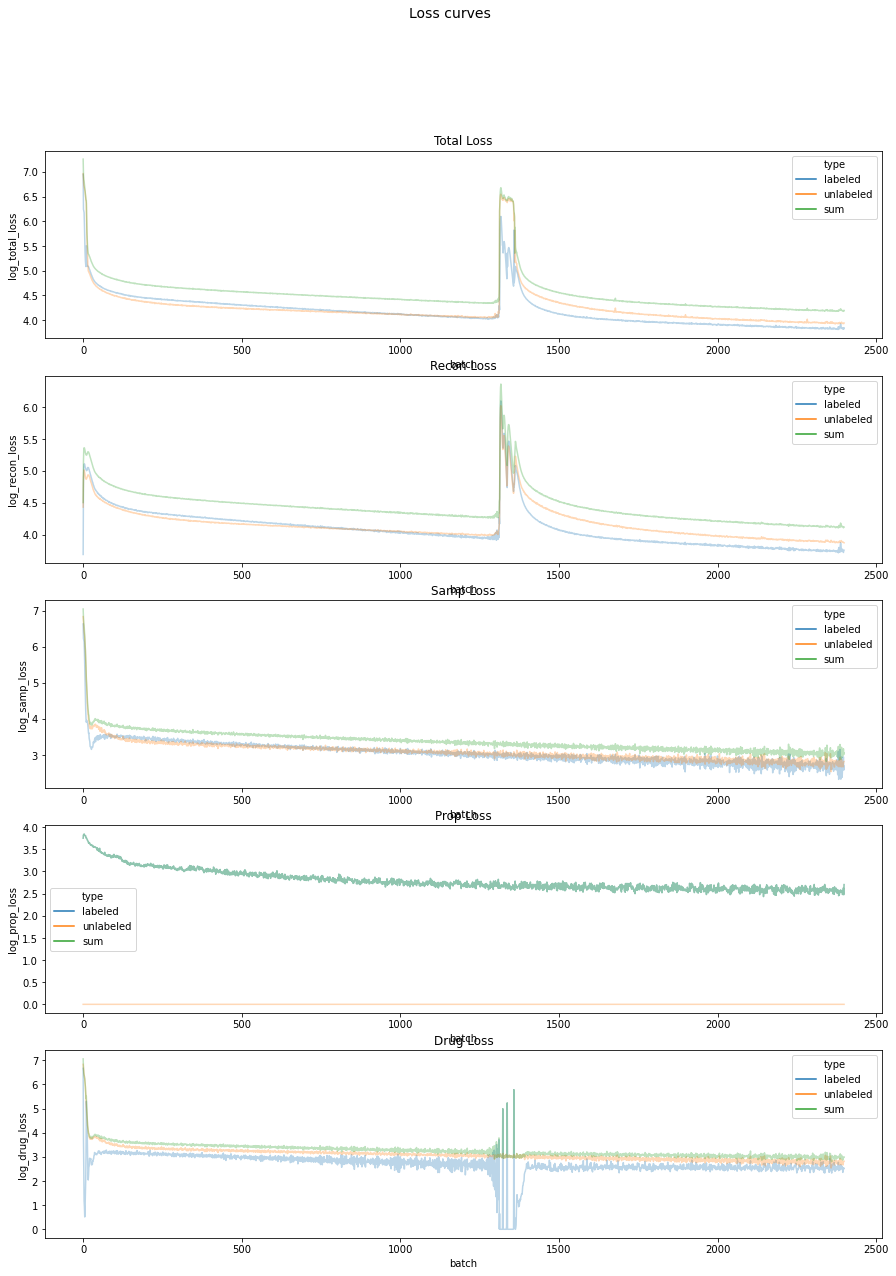

In [133]:

# add the log to make it easier to plot
loss_df["log_total_loss"] = np.log10(loss_df["total_loss"]+1)
loss_df["log_recon_loss"] = np.log10(loss_df["recon_loss"]+1)
loss_df["log_samp_loss"] = np.log10(loss_df["samp_loss"]+1)
loss_df["log_prop_loss"] = np.log10(loss_df["prop_loss"]+1)
loss_df["log_drug_loss"] = np.log10(loss_df["drug_loss"]+1)


fig, axs = plt.subplots(5, figsize=(15,20))

make_loss_fig(loss_df, ax=axs[0], title=f"Total Loss", loss_to_plot="log_total_loss")
make_loss_fig(loss_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="log_recon_loss")
make_loss_fig(loss_df, ax=axs[2], title=f"Samp Loss", loss_to_plot="log_samp_loss")
make_loss_fig(loss_df, ax=axs[3], title=f"Prop Loss", loss_to_plot="log_prop_loss")
make_loss_fig(loss_df, ax=axs[4], title=f"Drug Loss", loss_to_plot="log_drug_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

In [134]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g


def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


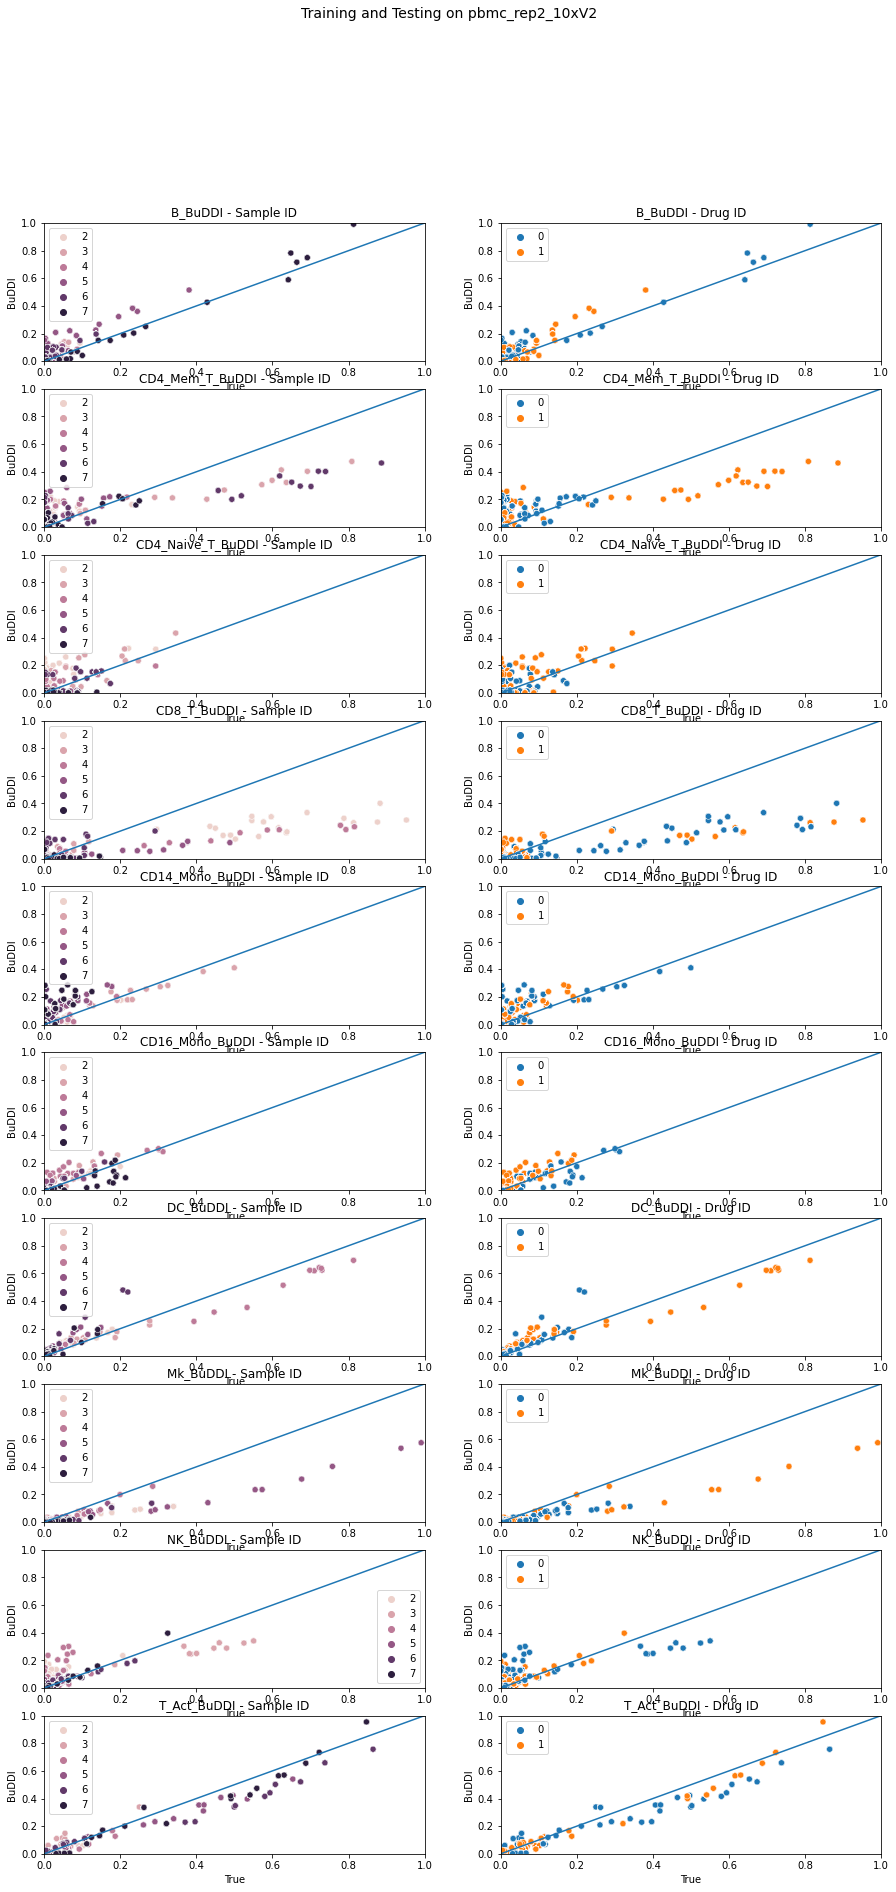

In [135]:
idx_tmp = np.where(Label_full >= 2)[0]
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_tmp]

fig, axs = plt.subplots(10, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

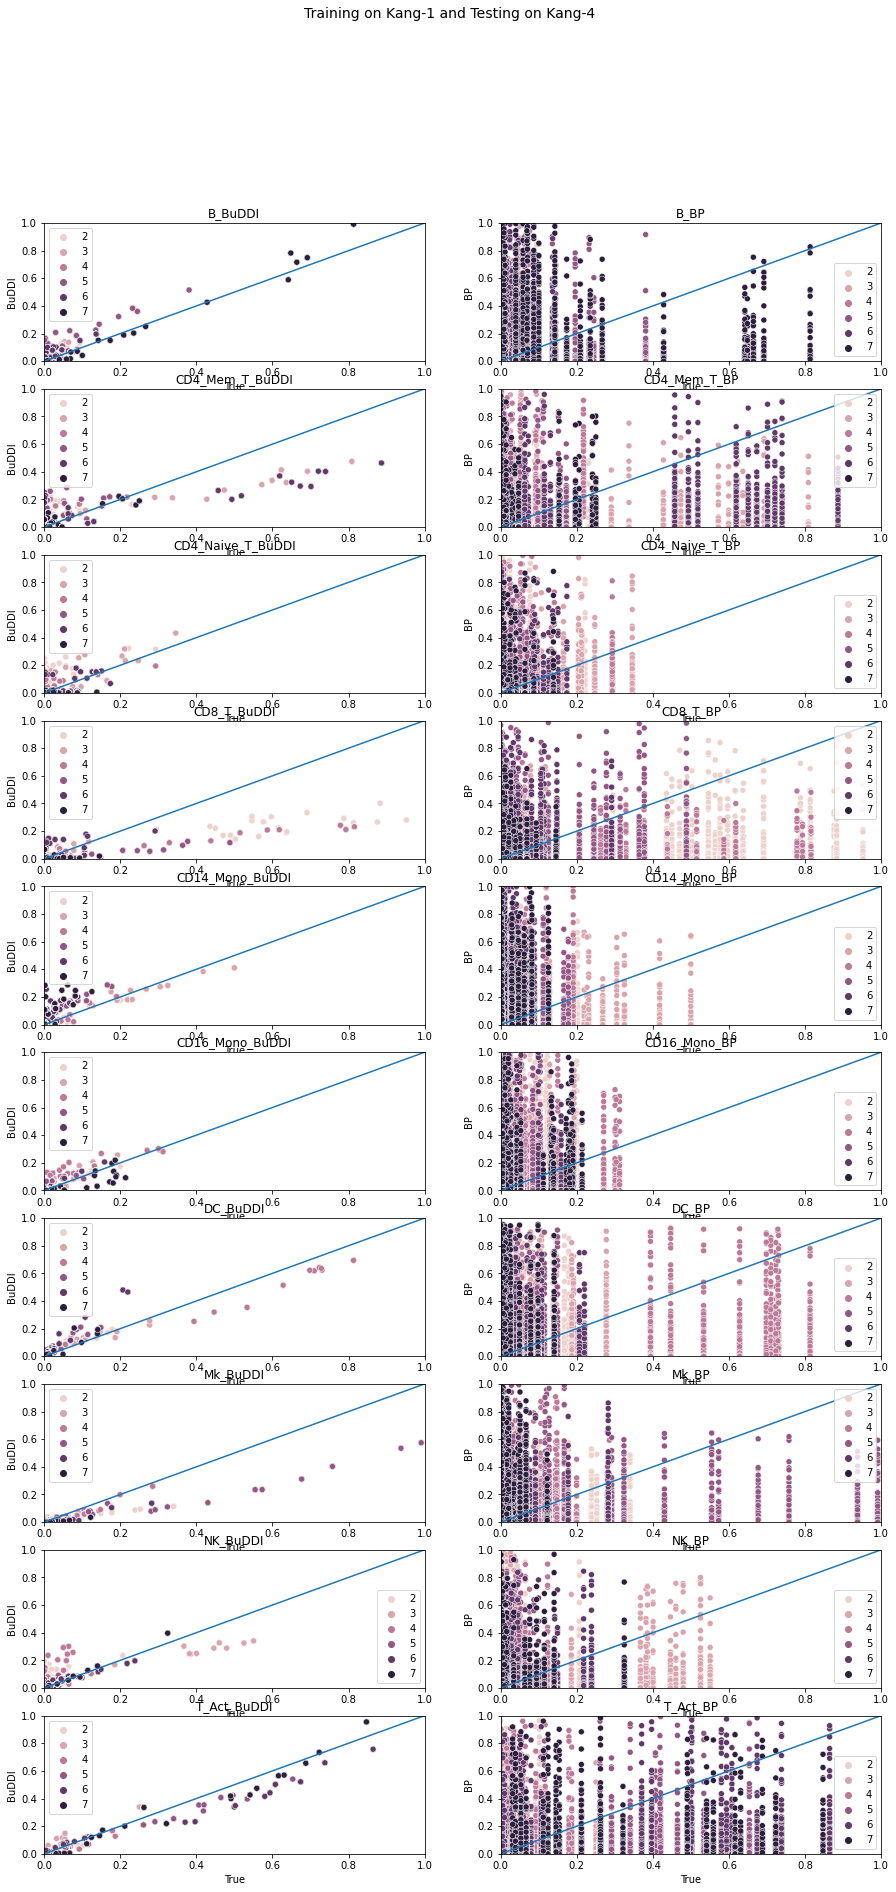

In [136]:
idx_tmp = idx_unlab
X_tmp = X_full[idx_tmp,]

y_cols = [str(x) for x in Y_train.columns]


# read in BP
bp_df  = read_bp_result_file(bp_res_path, "kang", "kang", num_samp=14000)
bp_df = bp_df.reindex(columns=y_cols, fill_value=0)


# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled
prop_df = pd.DataFrame(prop_outputs, columns=y_cols)
true_prop_df = Y_train.iloc[idx_tmp]



fig, axs = plt.subplots(10, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI", class_id=Label_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], bp_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP", class_id=Label_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Training on Kang-1 and Testing on Kang-4", fontsize=14)

fig.show()

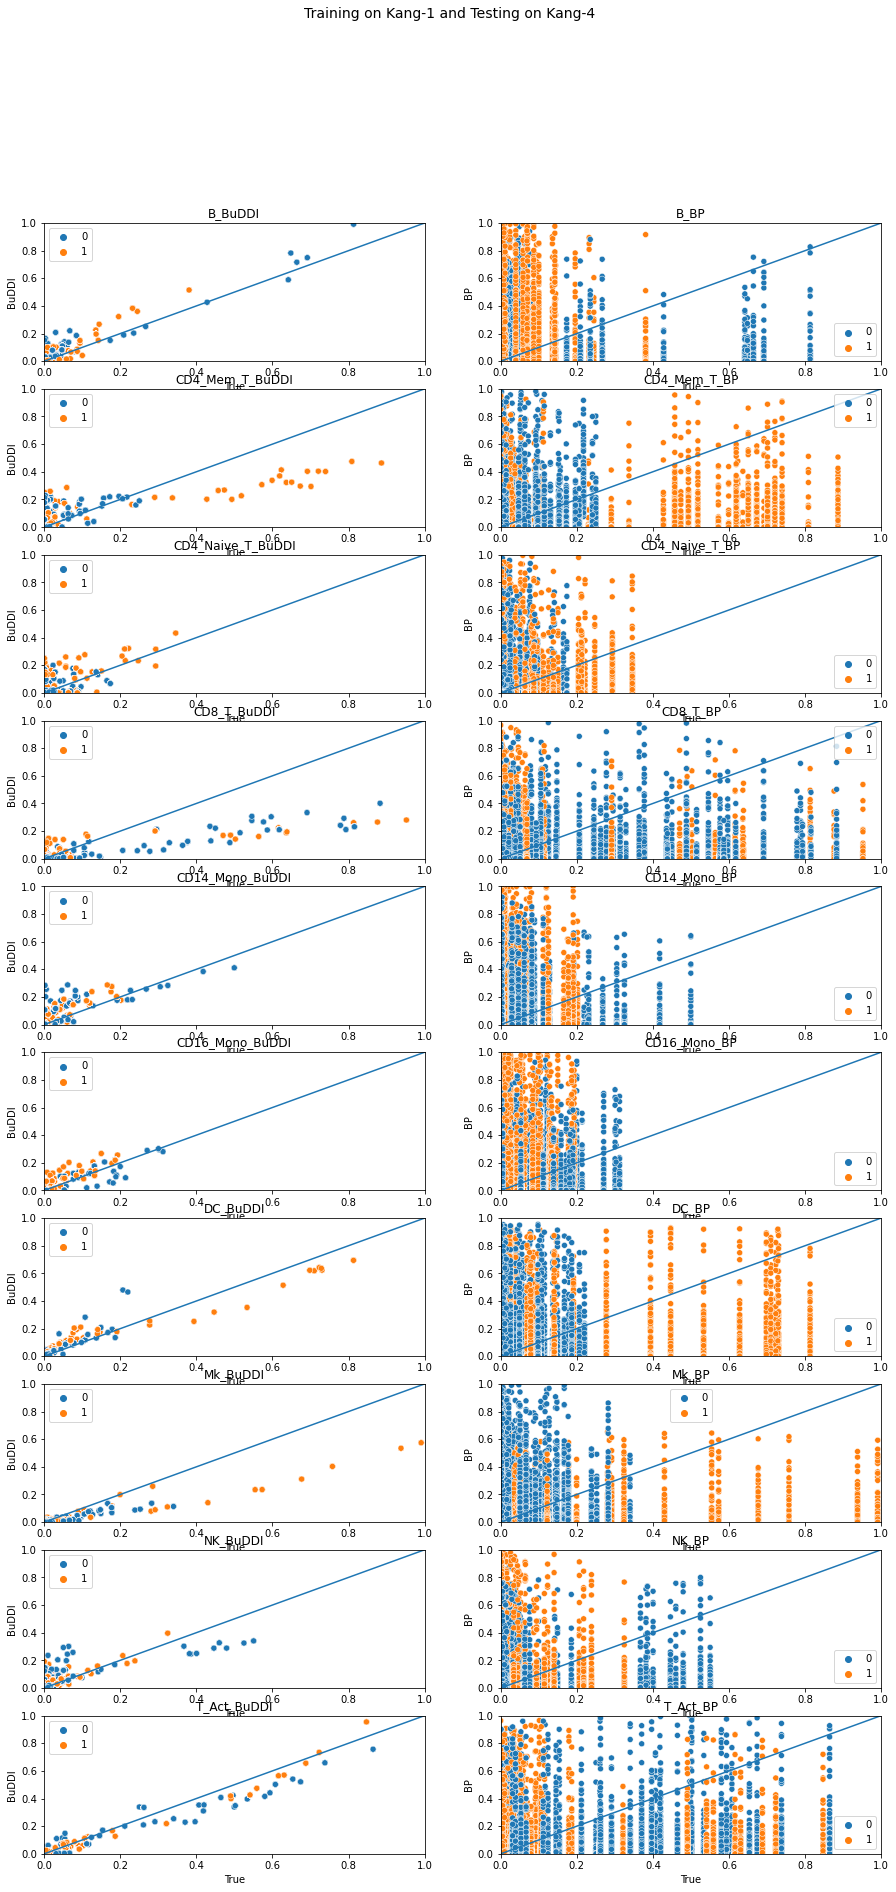

In [137]:
idx_tmp = idx_unlab
X_tmp = X_full[idx_tmp,]

y_cols = [str(x) for x in Y_train.columns]


# read in BP
bp_df  = read_bp_result_file(bp_res_path, "kang", "kang", num_samp=14000)
bp_df = bp_df.reindex(columns=y_cols, fill_value=0)


# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled
prop_df = pd.DataFrame(prop_outputs, columns=y_cols)
true_prop_df = Y_train.iloc[idx_tmp]



fig, axs = plt.subplots(10, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], bp_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP", class_id=Drug_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Training on Kang-1 and Testing on Kang-4", fontsize=14)

fig.show()

### compare errors

In [138]:
def read_diva_result_file(res_path, train_id, test_id, unlab_id):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-DIVA.pkl")
    res_path = Path(res_file)
    res_df = pickle.load( open( res_path, "rb" ) )
    return res_df

def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df




In [139]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


def get_errors_single(y_true, y_est):
  mse_err = [mean_sqr_error(y_true, y_est)]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true, y_est)[0]]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true, y_est)[0]]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"] + ["SPR"] + ["PEAR"]

  return plot_df




MSqE mean: 0.028794267460701215, median: 0.023964660864315382, max: 0.058918229313927095
Spearman mean: 0.47907937893175323, median: 0.48484848484848475, max: 0.7333333333333332
Pearson mean: 0.5257218746485791, median: 0.5416382476509676, max: 0.705403302627745
MSqE mean: 0.0667056379408304, median: 0.06100291124834328, max: 0.1593688711034752
Spearman mean: -0.14027965757907124, median: -0.14350612394269036, max: 0.7696969696969697
Pearson mean: -0.19303118557321172, median: -0.23265252189284846, max: 0.8809773424018037
MSqE mean: 0.07110089848723977, median: 0.06713109099498216, max: 0.17755900830779536
Spearman mean: -0.046905142630430746, median: -0.05454545454545454, max: 0.8303030303030302
Pearson mean: -0.08297451173918582, median: -0.16720570593880324, max: 0.9912761932880974


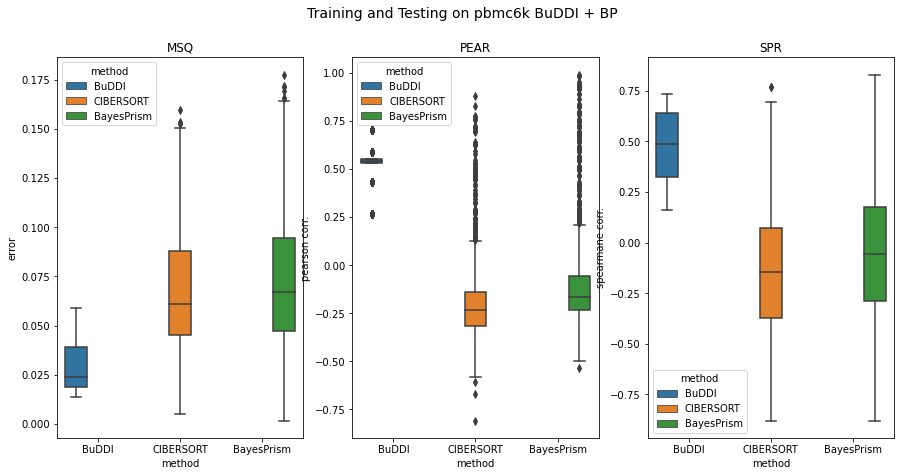

In [140]:
# We only ran the cibersort on index 9
idx_9 = np.where(np.logical_and(Label_full == 2, Drug_full == 1))[0]
X_tmp = X_full[idx_9,]
Y_tmp = Y_train.iloc[idx_9]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# read in cibersort
cibersort_df = pd.read_csv(cibersort_file_path)
cibersort_df = cibersort_df.reindex(columns=Y_train.columns, fill_value=0)


# read in BP
bp_df  = read_bp_result_file(bp_res_path, "kang", "kang", num_samp=14000)
bp_df = bp_df.reindex(columns=y_cols, fill_value=0)
bp_df = bp_df.iloc[range(2000, 3000)] 


# calculate the error
buddi_err = get_errors(Y_tmp.to_numpy(), prop_outputs)
cibersort_err = get_errors(Y_tmp.to_numpy(), cibersort_df.to_numpy())
bp_err = get_errors(Y_tmp.to_numpy(), bp_df.to_numpy())

# format the errors
buddi_err["experiment"] = ["true_val"]*buddi_err.shape[0]
buddi_err["method"] = ["BuDDI"]*buddi_err.shape[0]

cibersort_err["experiment"] = ["true_val"]*cibersort_err.shape[0]
cibersort_err["method"] = ["CIBERSORT"]*cibersort_err.shape[0]

bp_err["experiment"] = ["true_val"]*bp_err.shape[0]
bp_err["method"] = ["BayesPrism"]*bp_err.shape[0]

plot_df = pd.concat([buddi_err, cibersort_err, bp_err])

# plot
fig, axs = plt.subplots(1, 3, figsize=(15,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
fig.suptitle("Training on 1, testing on 4", fontsize=14)


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="method", y="error",
            hue="method", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Training and Testing on pbmc6k BuDDI + BP", fontsize=14)


fig.show()

MSqE mean: 0.011194501810105567, median: 0.008052568220546792, max: 0.058918229313927095
Spearman mean: 0.6083875214540505, median: 0.6373322286138521, max: 0.9515151515151514
Pearson mean: 0.794947245775846, median: 0.8577549201421905, max: 0.9978533108440043
MSqE mean: 0.05869112628180767, median: 0.05507269664825161, max: 0.19630519941524102
Spearman mean: 0.007220972398429784, median: 0.006060606060606061, max: 0.9515151515151514
Pearson mean: -0.009976389690295828, median: -0.11720676063767065, max: 0.9971198012526221


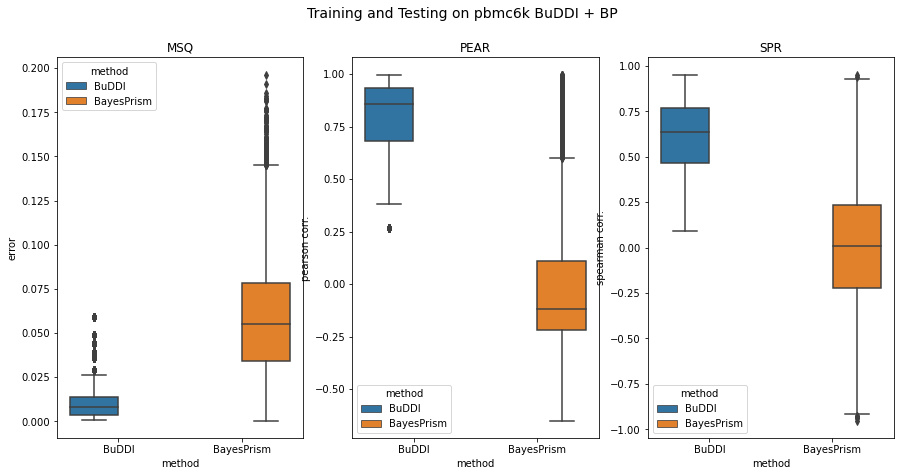

In [141]:

X_tmp = X_full[idx_tmp,]
Y_tmp = Y_train.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# read in BP
bp_df  = read_bp_result_file(bp_res_path, "kang", "kang", num_samp=14000)
bp_df = bp_df.reindex(columns=y_cols, fill_value=0)


# calculate the error
buddi_err = get_errors(Y_tmp.to_numpy(), prop_outputs)
bp_err = get_errors(Y_tmp.to_numpy(), bp_df.to_numpy()[2000:14000,])

# format the errors
buddi_err["experiment"] = ["true_val"]*buddi_err.shape[0]
buddi_err["method"] = ["BuDDI"]*buddi_err.shape[0]

bp_err["experiment"] = ["true_val"]*bp_err.shape[0]
bp_err["method"] = ["BayesPrism"]*bp_err.shape[0]

plot_df = pd.concat([buddi_err, bp_err])

# plot
fig, axs = plt.subplots(1, 3, figsize=(15,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
fig.suptitle("Training on 1, testing on 4", fontsize=14)


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="method", y="error",
            hue="method", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearman corr.")
fig.suptitle("Training and Testing on pbmc6k BuDDI + BP", fontsize=14)


fig.show()

MSqE mean: 0.011194501810105567, median: 0.008052568220546792, max: 0.058918229313927095
Spearman mean: 0.6083875214540505, median: 0.6373322286138521, max: 0.9515151515151514
Pearson mean: 0.794947245775846, median: 0.8577549201421905, max: 0.9978533108440043
MSqE mean: 0.05869112628180767, median: 0.05507269664825161, max: 0.19630519941524102
Spearman mean: 0.007220972398429784, median: 0.006060606060606061, max: 0.9515151515151514
Pearson mean: -0.009976389690295828, median: -0.11720676063767065, max: 0.9971198012526221


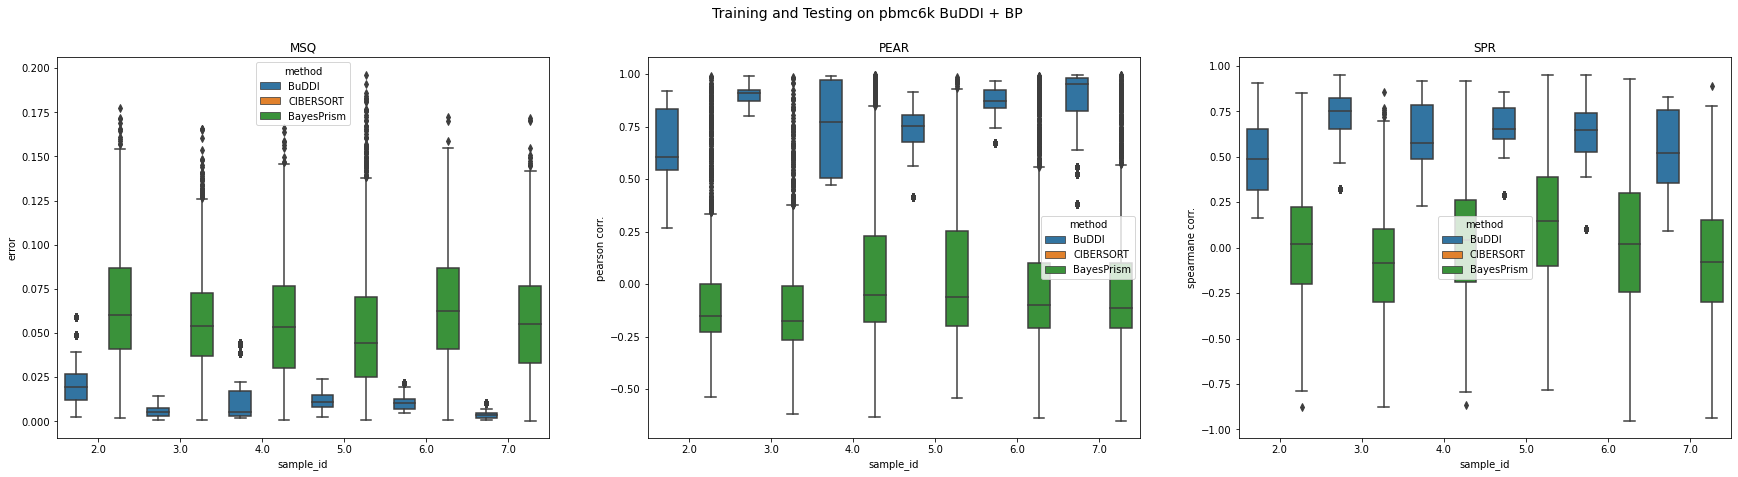

In [142]:
# Now compare across samples
idx_tmp = idx_unlab
num_unlab = np.array([0,1,2,2,3,3,4,4,5,5,6,6,7,7])
num_unlab = np.array([2,2,3,3,4,4,5,5,6,6,7,7])
idx_tmp = idx_unlab
X_tmp = X_full[idx_tmp,]
Y_tmp = Y_train.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err = get_errors(Y_tmp.to_numpy(), prop_outputs)
bp_err = get_errors(Y_tmp.to_numpy(), bp_df.to_numpy()[2000:14000])


# format the errors
buddi_err["experiment"] = ["true_val"]*buddi_err.shape[0]
buddi_err["method"] = ["BuDDI"]*buddi_err.shape[0]
buddi_err["sample_id"] = np.tile(np.repeat(num_unlab, 1000), 3)

bp_err["experiment"] = ["true_val"]*bp_err.shape[0]
bp_err["method"] = ["BayesPrism"]*bp_err.shape[0]
bp_err["sample_id"] = np.tile(np.repeat(num_unlab, 1000), 3)

plot_df = pd.concat([buddi_err, cibersort_err, bp_err])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="method", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Training and Testing on pbmc6k BuDDI + BP", fontsize=14)

fig.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

In [143]:
import umap

def get_umap_for_plotting(encodings):
    fit = umap.UMAP()
    umap_results = fit.fit_transform(encodings)

    plot_df = pd.DataFrame(umap_results[:,0:2])
    print(umap_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['umap_0', 'umap_1']
    return plot_df

def plot_umap(plot_df, color_vec, ax, title="", alpha=0.3):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="umap_0", y="umap_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=alpha, ax= ax
    )

    ax.set_title(title)
    return g


In [144]:
def get_tsne_for_plotting(encodings):
    tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
    tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title=""):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g


In [145]:
from sklearn.decomposition import PCA

def get_pca_for_plotting(encodings):
    fit = PCA(n_components=2)
    pca_results = fit.fit_transform(encodings)

    plot_df = pd.DataFrame(pca_results[:,0:2])
    print(pca_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['PCA_0', 'PCA_1']
    return plot_df

def plot_pca(plot_df, color_vec, ax, title="", alpha=0.1):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="PCA_0", y="PCA_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=alpha, ax= ax
    )

    ax.set_title(title)
    return g

## Plot Reconstruction

In [146]:

X_temp = np.copy(X_full)


label_temp = np.copy(Label_full)
perturb_temp = Drug_full
source_temp = np.asarray([0]*10000)


# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([z_slack, Y_train, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(16000, 2)
(16000, 2)


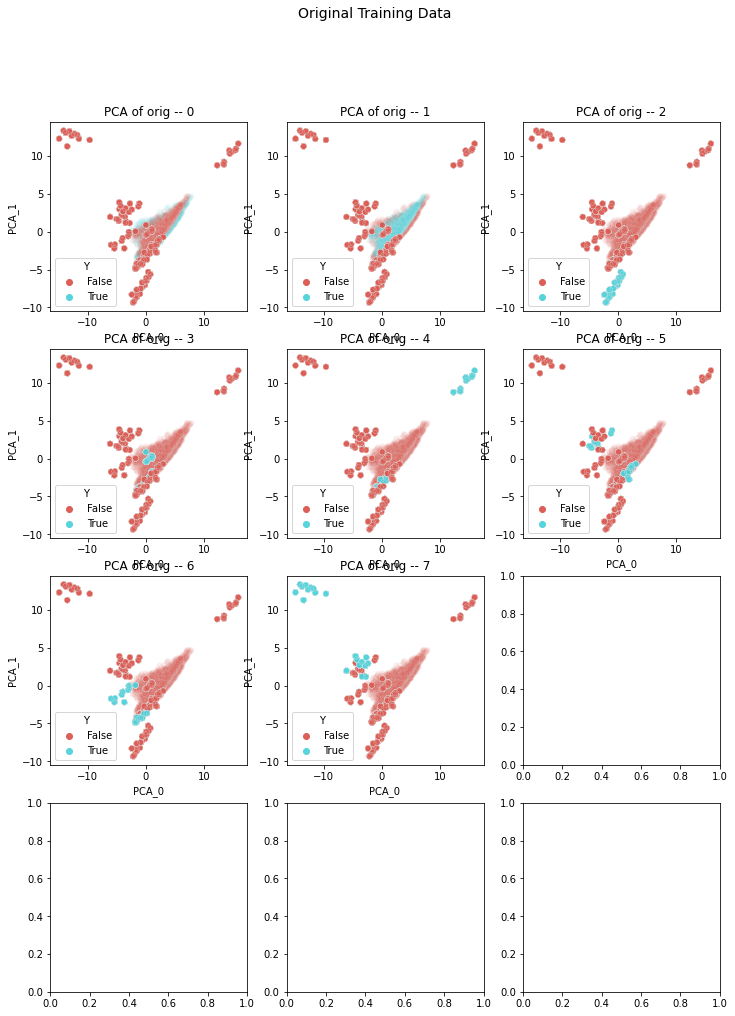

In [147]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = get_pca_for_plotting(np.asarray(X_temp))
plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of orig -- 0")
plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of orig -- 1")
plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of orig -- 2")
plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of orig -- 3")
plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of orig -- 4")
plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of orig -- 5")
plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of orig -- 6")
plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of orig -- 7")


fig.suptitle("Original Training Data", fontsize=14)

fig.show()

(16000, 2)
(16000, 2)


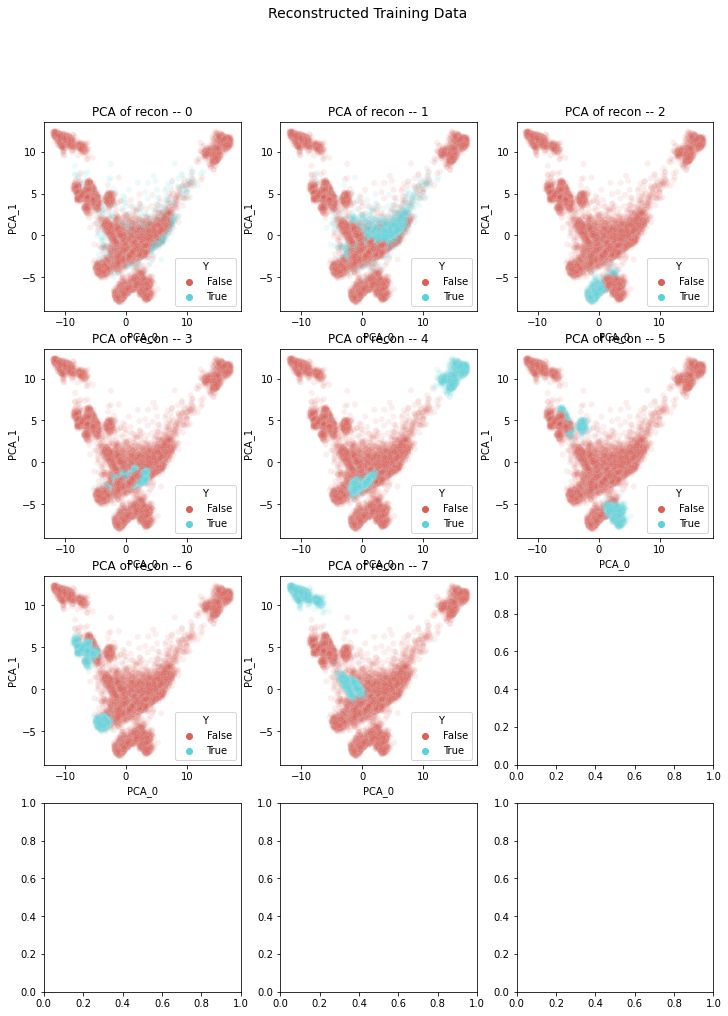

In [148]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = get_pca_for_plotting(np.asarray(decoded_outputs))
plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of recon -- 0")
plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of recon -- 1")
plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of recon -- 2")
plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of recon -- 3")
plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of recon -- 4")
plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of recon -- 5")
plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of recon -- 6")
plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of recon -- 7")


fig.suptitle("Reconstructed Training Data", fontsize=14)

fig.show()

(32000, 2)
(32000, 2)


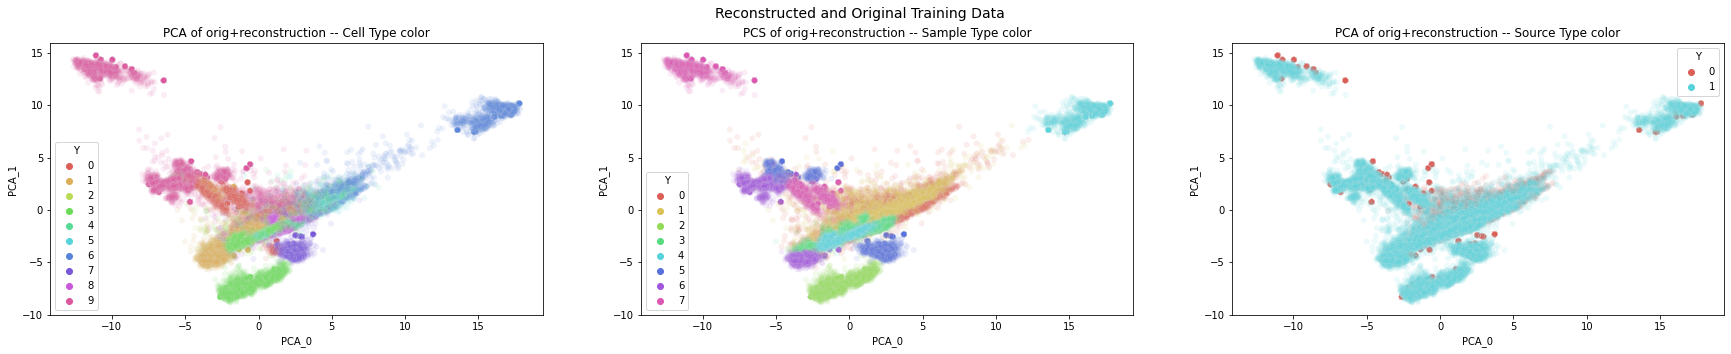

In [149]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])


Y_temp = np.copy(Y_train)
Y_temp = np.argmax(Y_temp, axis=1)
Y_dup = np.append(Y_temp, Y_temp)

label_dup = np.append(label_temp, label_temp)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*16000, [1]*16000))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = get_pca_for_plotting(np.asarray(X_dup))
plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")


fig.suptitle("Reconstructed and Original Training Data", fontsize=14)

fig.show()

### Plot latent spaces

Number unique Y: 9
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)


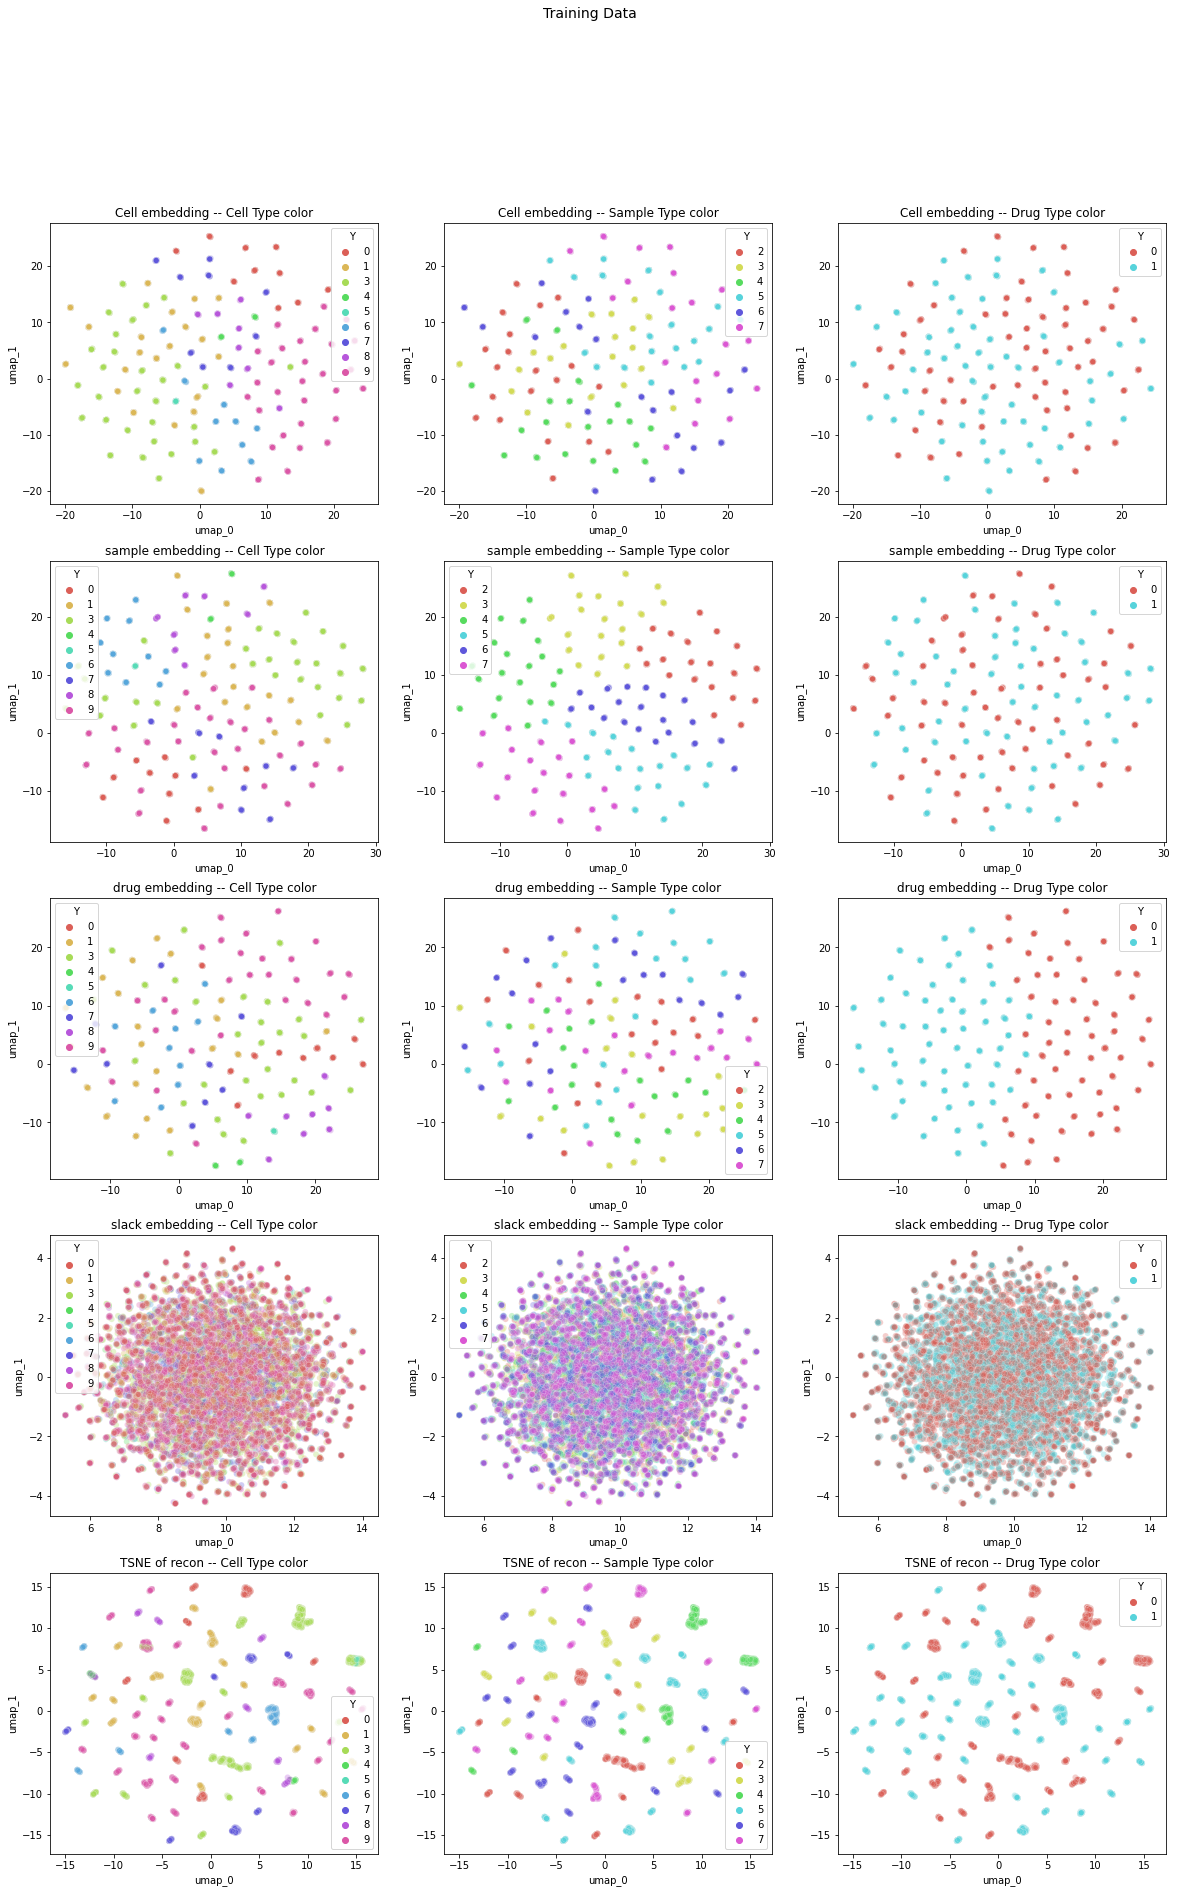

In [150]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_tmp = idx_unlab

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_train)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(5, 3, figsize=(20,30))

plot_df = get_umap_for_plotting(np.asarray(prop_outputs))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(mu_rot))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(mu_drug))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(mu_slack))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[3,0], title="slack embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[3,1], title="slack embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="slack embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(decoded_outputs))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[4,0], title="TSNE of recon -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[4,1], title="TSNE of recon -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[4,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

Number unique Y: 9
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)


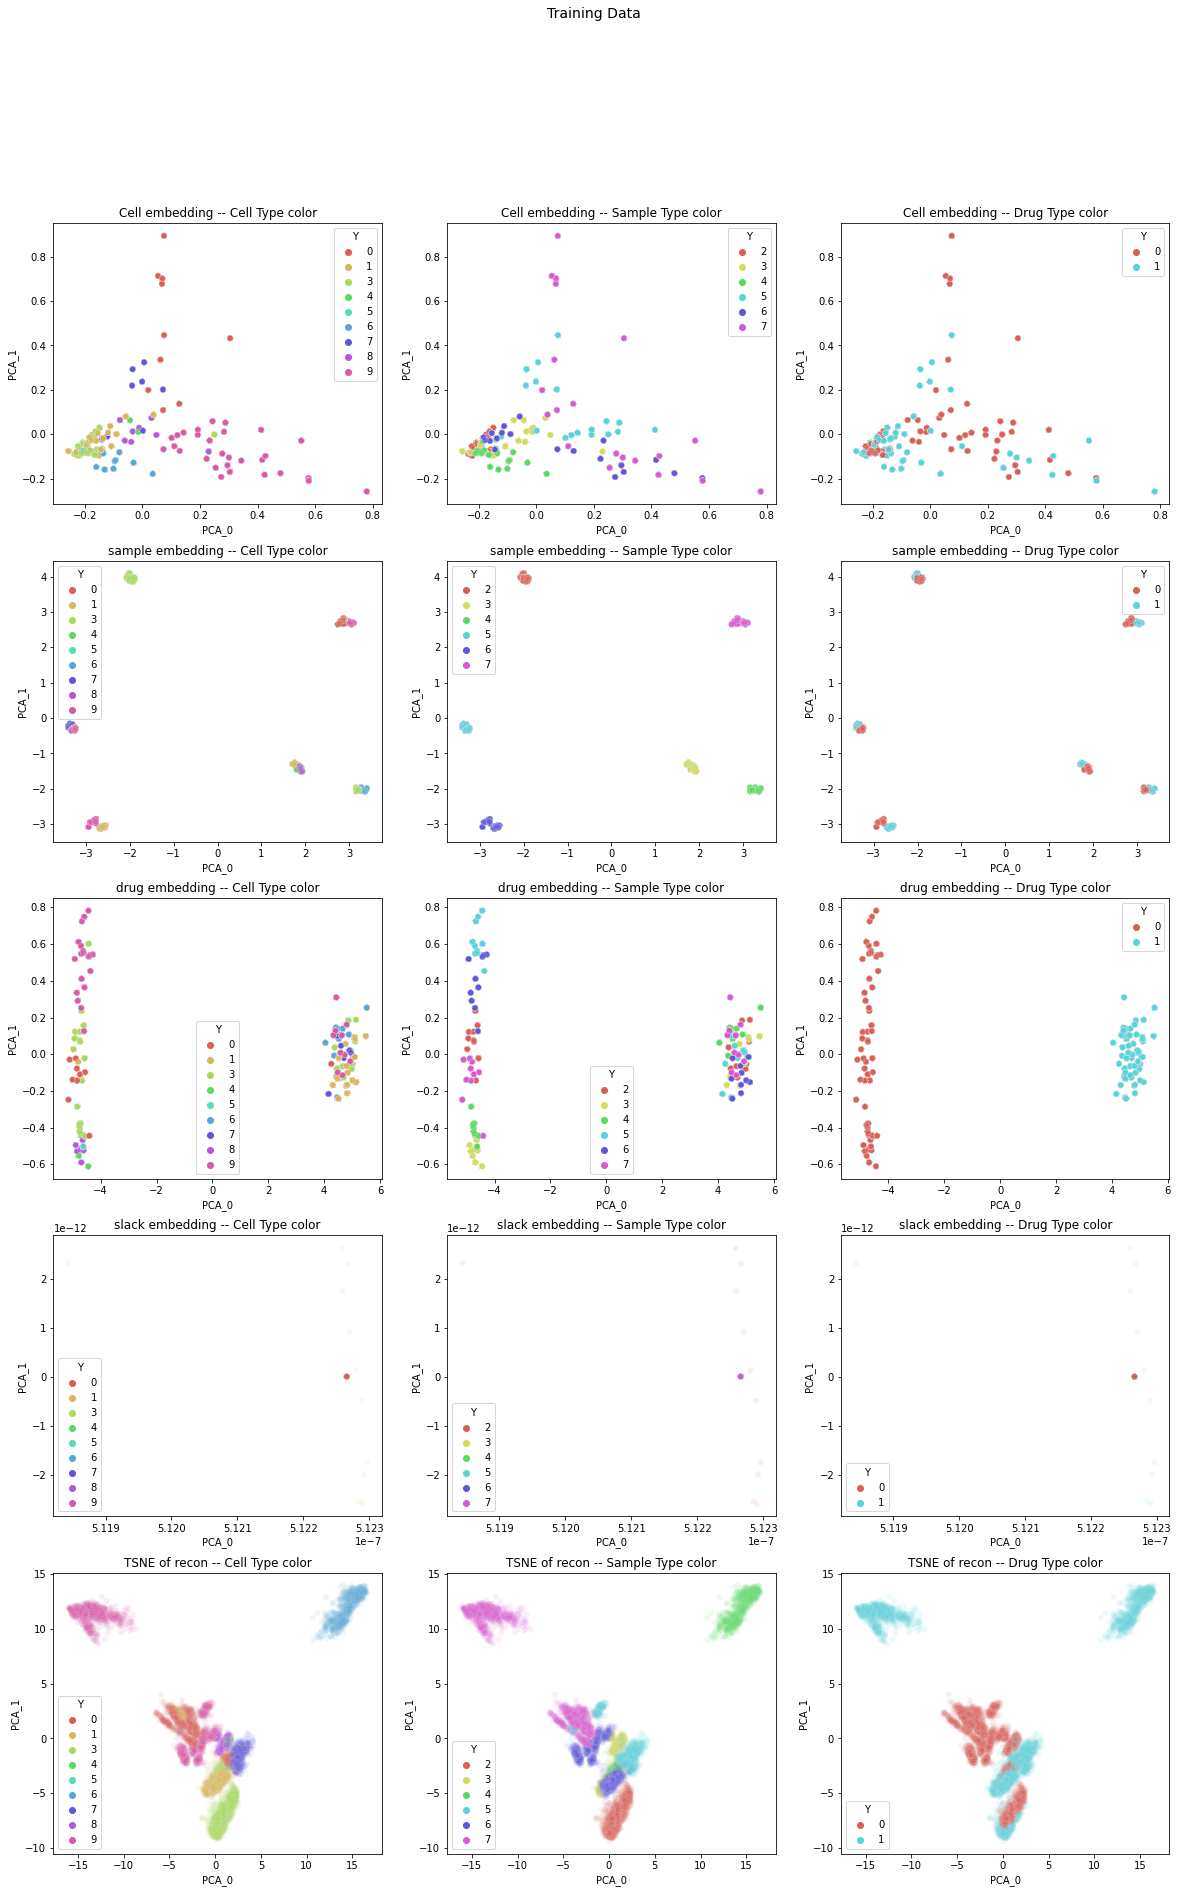

In [151]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_tmp = idx_unlab

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_train)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(5, 3, figsize=(20,30))

plot_df = get_pca_for_plotting(np.asarray(prop_outputs))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = get_pca_for_plotting(np.asarray(mu_rot))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = get_pca_for_plotting(np.asarray(mu_drug))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = get_pca_for_plotting(np.asarray(mu_slack))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[3,0], title="slack embedding -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[3,1], title="slack embedding -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="slack embedding -- Drug Type color")

plot_df = get_pca_for_plotting(np.asarray(decoded_outputs))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[4,0], title="TSNE of recon -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[4,1], title="TSNE of recon -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[4,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

## Do latent space projectsions

In [152]:
# this is to generate noisy vector where the second elements is the largest
def add_vec_noise():
    a = np.random.lognormal(mean=0, sigma=1, size=10) + np.array([0,0,0,0,0,100,0, 0, 0, 0])
    return a/a.sum()


### drug perturbation

In [153]:
Drug_full

array([1, 1, 1, ..., 0, 0, 0])

In [154]:
np.where(np.logical_and(perturb_temp == 1, np.logical_and(label_temp == 7, Y_temp == 2)))[0]

array([], dtype=int64)

In [155]:
# now we will take one cell type and project it across different sample IDs.
# this will allow us to see how well the reconstruction does
label_temp = np.copy(Label_full)
perturb_temp = np.copy(Drug_full)

X_temp = np.copy(X_orig)

prop_outputs = classifier.predict(X_temp, batch_size=batch_size)
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)


# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)

# first take all the samples from patient 0 where cell_4 is the max and not perturbed
label_temp = np.copy(Label_full)
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)
idx_0_patient = np.where(np.logical_and(perturb_temp == 0, np.logical_and(label_temp == 7, Y_temp == 2)))[0]

# and take a random set of the samples from patients with a perturbation 
# of the length of idx_0_patient
# this is because we will use this random sample as our translation
idx_1_patient = np.where(perturb_temp == 1)[0]
idx_1_patient = np.random.choice(idx_1_patient, len(idx_0_patient))

# now for patient 0, cell type 0
# we are shifting it to patient 1 cell type 0
# cell type should remain the same because the latent spaces are
# disentangled and we are not changing Y
z_drug_perturb = np.copy(z_drug)
z_drug_perturb[idx_0_patient,] = z_drug_perturb[idx_1_patient,]

# now concatenate together and decode
z_concat_unlab_perturb = np.hstack([z_slack, prop_outputs, z_rot, z_drug_perturb])
decoded_0_1 = decoder.predict(z_concat_unlab_perturb, batch_size=batch_size)
decoded_0_1 = scaler.inverse_transform(decoded_0_1)


# compare with original
z_concat_unlab_UNperturb = np.hstack([z_slack, prop_outputs, z_rot, z_drug])
decoded_0_0 = decoder.predict(z_concat_unlab_UNperturb, batch_size=batch_size)
decoded_0_0 = scaler.inverse_transform(decoded_0_0)




(16000, 2)
(16000, 2)


/tmp/ipykernel_5798/563184163.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


(16000, 2)
(16000, 2)


/tmp/ipykernel_5798/563184163.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


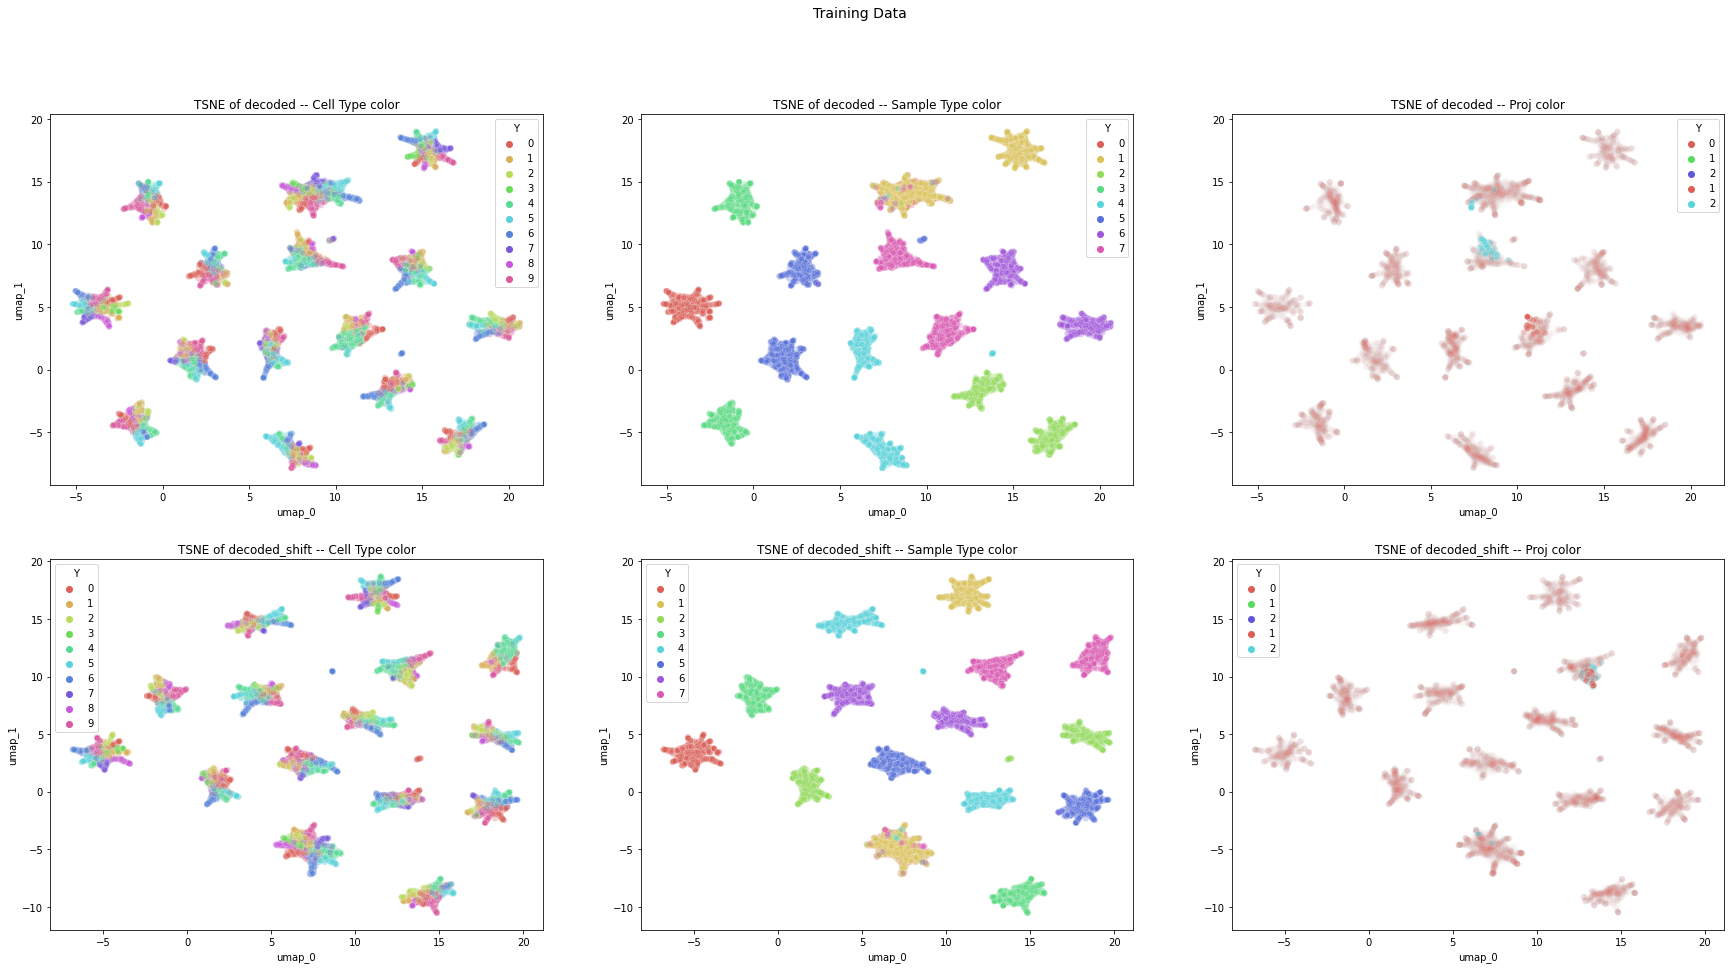

In [156]:
# Plot all patients

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)

idx_proj_cell0 = np.where(np.logical_and(perturb_temp == 0, np.logical_and(Y_temp == 2, label_temp == 7)))[0]
idx_reg_cell0 = np.where(np.logical_and(perturb_temp == 1, np.logical_and(Y_temp == 2, label_temp == 7)))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 samp 0"
proj_temp[idx_reg_cell0] = 2 #"cell0 samp 1"


only_cell_0_interest = np.union1d(idx_proj_cell0, idx_reg_cell0)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

plot_df = get_umap_for_plotting(np.asarray(decoded_0_0))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp, ax=axs[0,2], title="TSNE of decoded -- Proj color", alpha=0.01)
plot_umap(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[0,2], title="TSNE of decoded -- Proj color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp, ax=axs[1,2], title="TSNE of decoded_shift -- Proj color", alpha=0.01)
plot_umap(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color")


fig.suptitle("Training Data", fontsize=14)

fig.show()



(16000, 2)
(16000, 2)


/tmp/ipykernel_5798/4280157301.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


(16000, 2)
(16000, 2)


/tmp/ipykernel_5798/4280157301.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


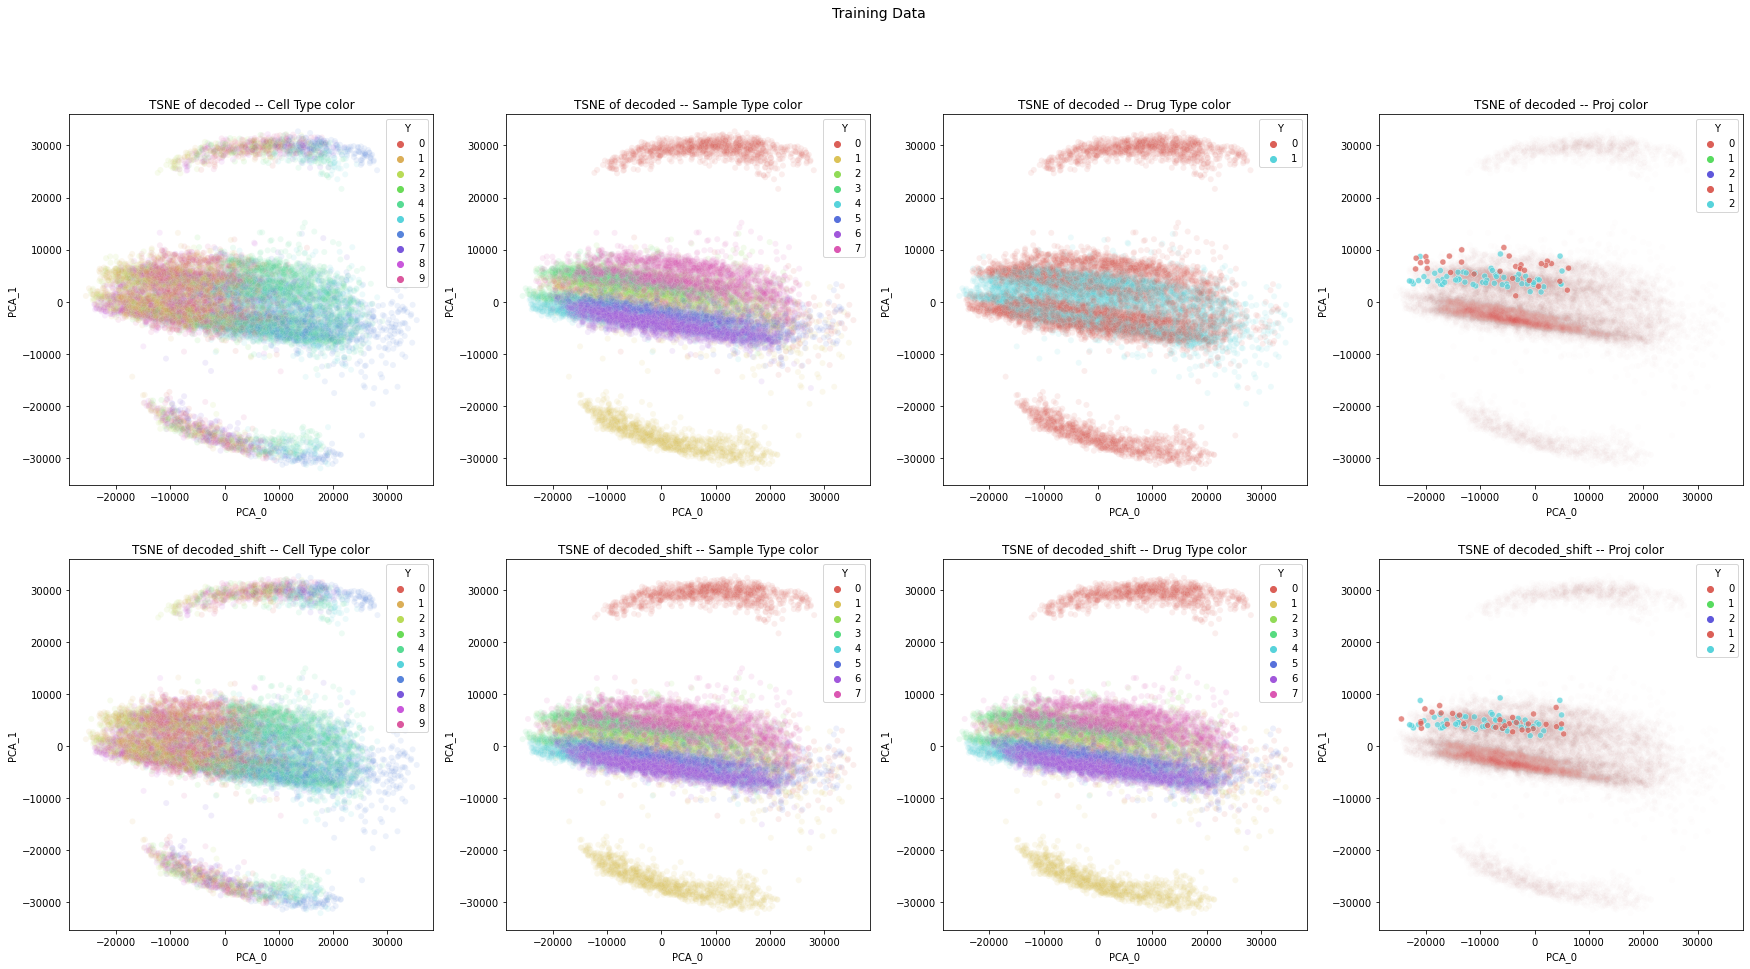

In [157]:
# Plot all patients

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)

idx_proj_cell0 = np.where(np.logical_and(perturb_temp == 0, np.logical_and(Y_temp == 2, label_temp == 7)))[0]
idx_reg_cell0 = np.where(np.logical_and(perturb_temp == 1, np.logical_and(Y_temp == 2, label_temp == 7)))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 samp 0"
proj_temp[idx_reg_cell0] = 2 #"cell0 samp 1"


only_cell_0_interest = np.union1d(idx_proj_cell0, idx_reg_cell0)

fig, axs = plt.subplots(2, 4, figsize=(30,15))

plot_df = get_pca_for_plotting(np.asarray(decoded_0_0))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,0], title="TSNE of decoded -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[0,1], title="TSNE of decoded -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="TSNE of decoded -- Drug Type color")
plot_pca(plot_df, color_vec=proj_temp, ax=axs[0,3], title="TSNE of decoded -- Proj color", alpha=0.01)
plot_pca(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[0,3], title="TSNE of decoded -- Proj color", alpha=0.7)

plot_df = get_pca_for_plotting(np.asarray(decoded_0_1))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[1,2], title="TSNE of decoded_shift -- Drug Type color")
plot_pca(plot_df, color_vec=proj_temp, ax=axs[1,3], title="TSNE of decoded_shift -- Proj color", alpha=0.01)
plot_pca(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[1,3], title="TSNE of decoded_shift -- Proj color", alpha=0.7)


fig.suptitle("Training Data", fontsize=14)

fig.show()



(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


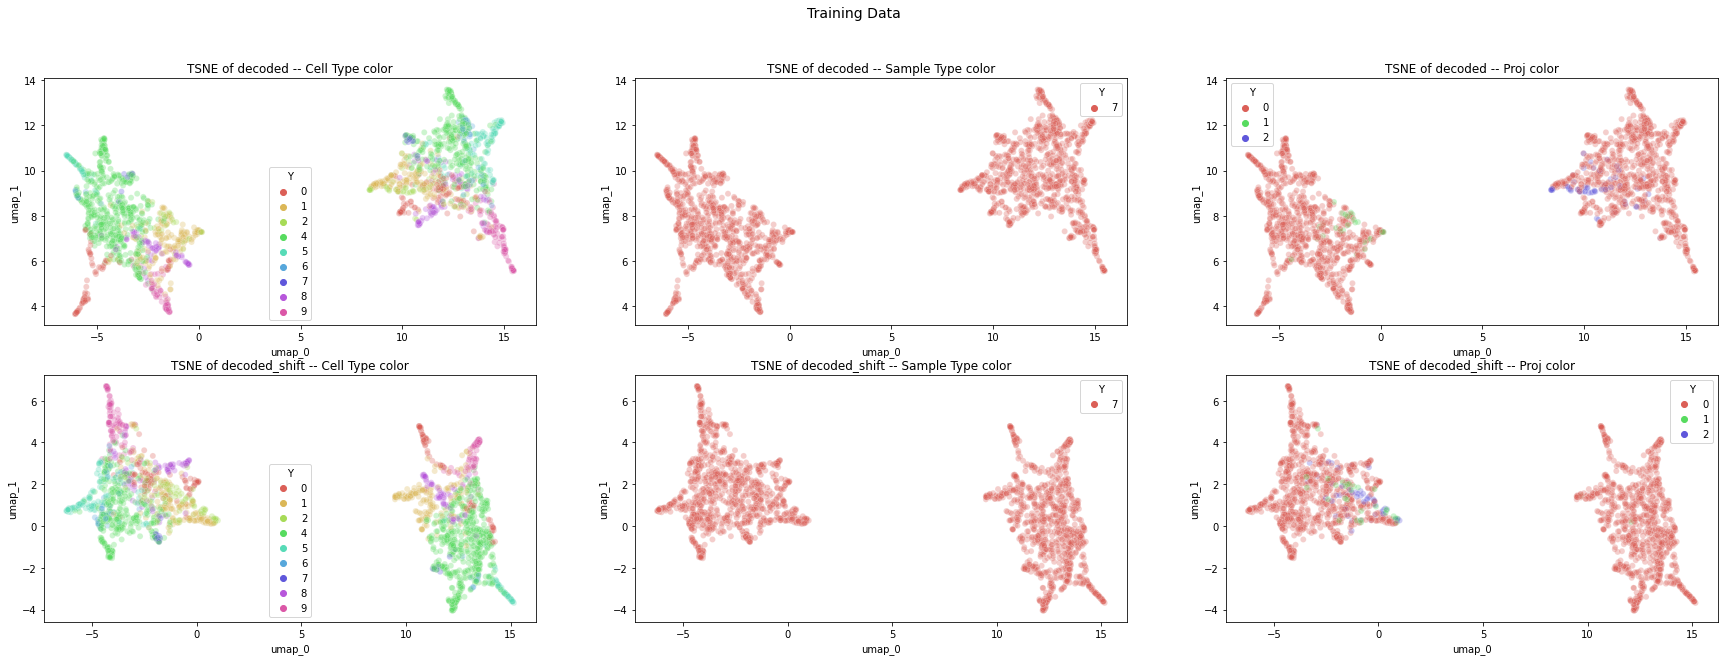

In [158]:
# Plot patient of interest

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)


idx_proj_cell0 = np.where(np.logical_and(perturb_temp == 0, np.logical_and(Y_temp == 2, label_temp == 7)))[0]
idx_reg_cell0 = np.where(np.logical_and(perturb_temp == 1, np.logical_and(Y_temp == 2, label_temp == 7)))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 projected to samp 1"
proj_temp[idx_reg_cell0] = 2 #"cell0 already in samp 1"


samp_0 = range(14000, 16000)

fig, axs = plt.subplots(2, 3, figsize=(30,10))


plot_df = get_umap_for_plotting(np.asarray(decoded_0_0[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[0,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp[samp_0], ax=axs[0,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp[samp_0], ax=axs[0,2], title="TSNE of decoded -- Proj color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp[samp_0], ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp[samp_0], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color")


fig.suptitle("Training Data", fontsize=14)

fig.show()



(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


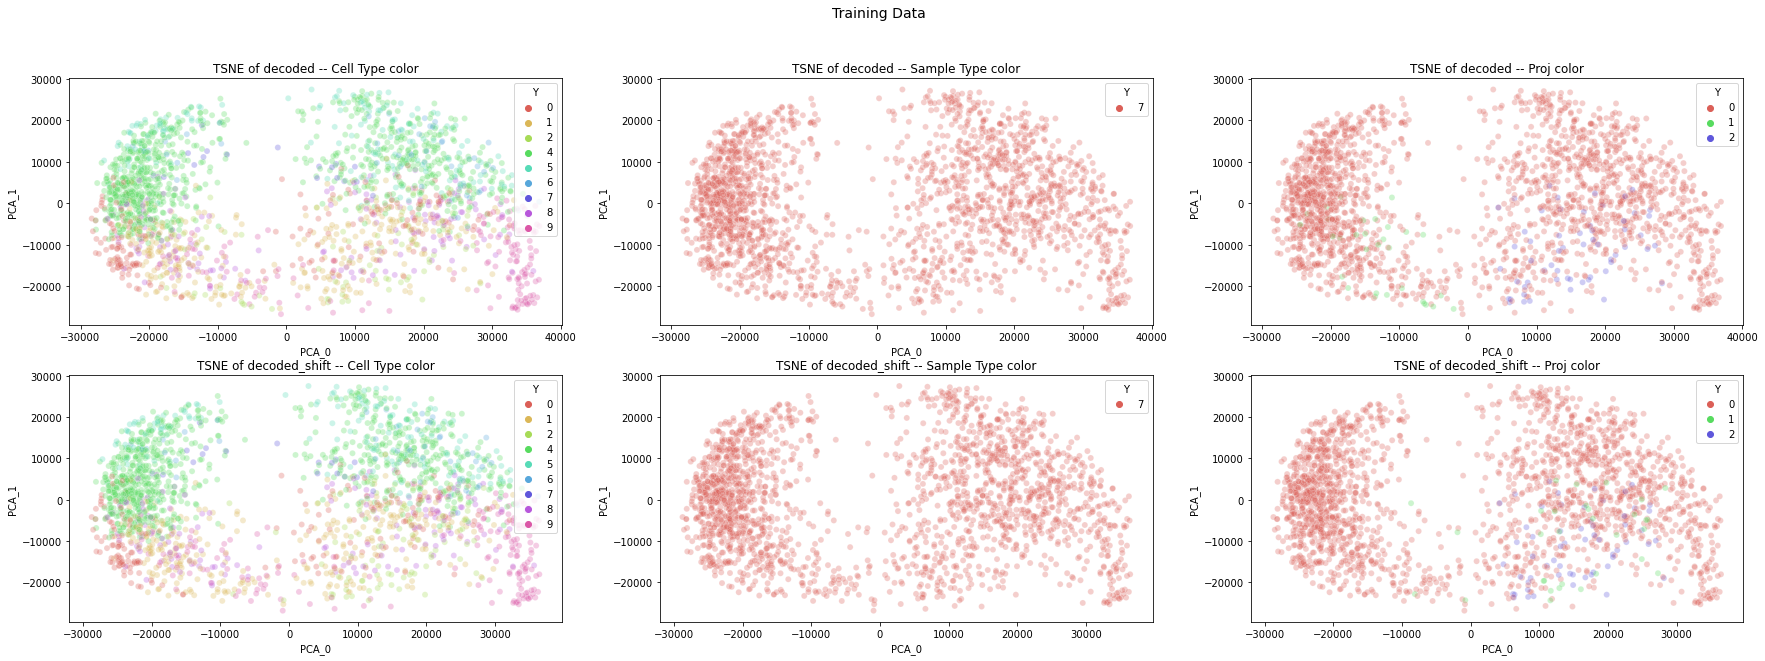

In [159]:
# Plot patient of interest

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)


idx_proj_cell0 = np.where(np.logical_and(perturb_temp == 0, np.logical_and(Y_temp == 2, label_temp == 7)))[0]
idx_reg_cell0 = np.where(np.logical_and(perturb_temp == 1, np.logical_and(Y_temp == 2, label_temp == 7)))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 projected to samp 1"
proj_temp[idx_reg_cell0] = 2 #"cell0 already in samp 1"


samp_0 = range(14000, 16000)

fig, axs = plt.subplots(2, 3, figsize=(30,10))


plot_df = get_pca_for_plotting(np.asarray(decoded_0_0[samp_0,]))
plot_pca(plot_df, color_vec=Y_temp[samp_0], ax=axs[0,0], title="TSNE of decoded -- Cell Type color", alpha=0.3)
plot_pca(plot_df, color_vec=label_temp[samp_0], ax=axs[0,1], title="TSNE of decoded -- Sample Type color", alpha=0.3)
plot_pca(plot_df, color_vec=proj_temp[samp_0], ax=axs[0,2], title="TSNE of decoded -- Proj color", alpha=0.3)

plot_df = get_pca_for_plotting(np.asarray(decoded_0_1[samp_0,]))
plot_pca(plot_df, color_vec=Y_temp[samp_0], ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color", alpha=0.3)
plot_pca(plot_df, color_vec=label_temp[samp_0], ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color", alpha=0.3)
plot_pca(plot_df, color_vec=proj_temp[samp_0], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color", alpha=0.3)


fig.suptitle("Training Data", fontsize=14)

fig.show()



In [160]:
def plot_expr_corr(xval, yval, ax, title, xlab, ylab, class_id, max_val=2700):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id,
        alpha=0.5
    )
    g.set(ylim=(0, max_val))
    g.set(xlim=(0, max_val))
    g.plot([0, max_val], [0, max_val], transform=g.transAxes)


    ax.set_title(title)
    return g


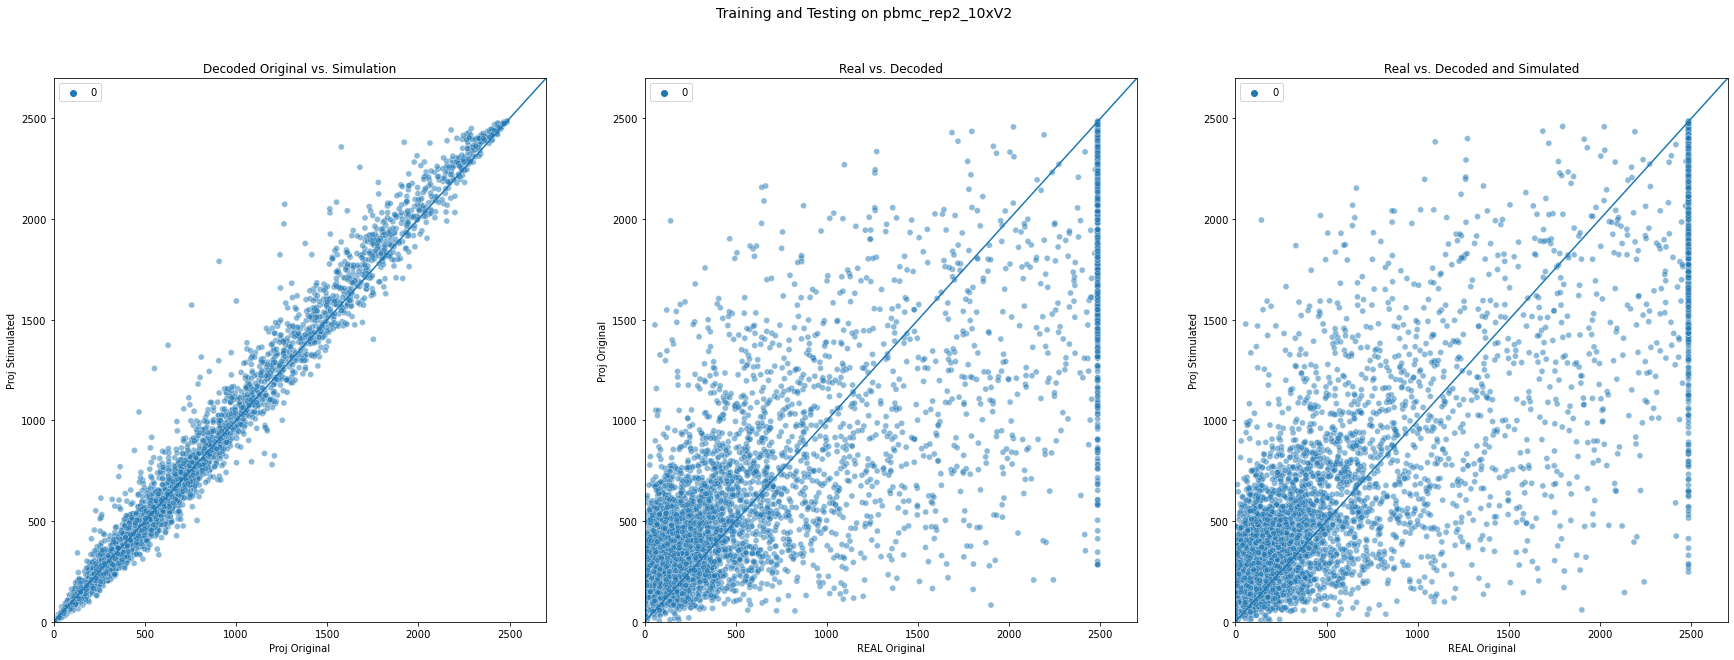

In [161]:
X_tmp = X_orig
X_tmp = scaler.inverse_transform(X_tmp)


idx_proj_cell0 = np.where(np.logical_and(perturb_temp == 0, np.logical_and(Y_temp == 2, label_temp == 7)))[0]
idx_reg_cell0 = np.where(np.logical_and(perturb_temp == 1, np.logical_and(Y_temp == 2, label_temp == 7)))[0]

projected_original = decoded_0_1[idx_reg_cell0,]
real_original = X_tmp[idx_reg_cell0,]
projected_simulated = decoded_0_1[idx_proj_cell0,]

projected_original = np.median(projected_original, axis=0)
real_original = np.median(real_original, axis=0)
projected_simulated = np.median(projected_simulated, axis=0)

class_color = [0]*len(projected_original)

fig, axs = plt.subplots(1, 3, figsize=(30,10))

plot_expr_corr(projected_original, projected_simulated, axs[0], title="Decoded Original vs. Simulation", xlab="Proj Original", ylab="Proj Stimulated", class_id=class_color)
plot_expr_corr(real_original, projected_original, axs[1], title="Real vs. Decoded", xlab="REAL Original", ylab="Proj Original", class_id=class_color)
plot_expr_corr(real_original, projected_simulated, axs[2], title="Real vs. Decoded and Simulated", xlab="REAL Original", ylab="Proj Stimulated", class_id=class_color)


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

In [162]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(real_original, projected_simulated)
coefficient_of_dermination

0.7450159549897597

## Compare gene expression between sim and non

In [163]:
# this is to generate noisy vector where the second elements is the largest
def add_vec_noise_idx(idx):
    in_vec =  np.array([0,0,0,0,0,0,0, 0, 0, 0])
    in_vec[idx] = 1000
    a = np.random.lognormal(mean=0, sigma=1, size=10) + in_vec
    return a/a.sum()


In [164]:
np.unique(label_temp)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [165]:
# simulate cell type specific perturbation effects


label_temp = np.copy(Label_full)
perturb_temp = np.copy(Drug_full)

#label_interest = np.unique(label_temp)
label_interest = np.array([ 2, 3, 4, 5, 6, 7])

X_temp = np.copy(X_orig)
X_invs = np.copy(X_orig)
X_invs = scaler.inverse_transform(X_invs)

# make num_samp_gen samples per sample_id
num_samp_gen = 100

all_res = [0]*Y_train.shape[1]

deseq_matr = None

for cell_idx in range(Y_train.shape[1]):

    curr_deseq_matr_0 = None
    curr_deseq_matr_1 = None

    for samp_idx in label_interest:

        # now use the encoder to get the latent spaces
        z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)

        # simulate 1 cell type
        noisy_prop_vec = [add_vec_noise_idx(cell_idx) for i in range(num_samp_gen)]
        noisy_prop_vec = np.vstack(noisy_prop_vec)

        # randomly sample the sample_ids (integrating over all latent codes)
        z_rot_samp_idx = np.where(np.logical_and(perturb_temp == 0, label_temp == samp_idx))[0]

        if z_rot_samp_idx.shape[0] == 0:
            continue
        
        z_rot_samp_idx = np.random.choice(z_rot_samp_idx, num_samp_gen)
        z_rot_samp_idx = np.sort(z_rot_samp_idx)
        z_rot_samp = z_rot[z_rot_samp_idx,]

        # randomly sample the slack (integrating over all latent codes)
        z_slack_samp_idx = np.sort(np.random.choice(range(z_slack.shape[0]), num_samp_gen))
        z_slack_samp = z_slack[z_slack_samp_idx,]

        # sample the the perturbed latent space
        z_drug_0_idx = np.random.choice(np.where(perturb_temp == 0)[0], num_samp_gen)
        z_drug_0_idx = np.sort(z_drug_0_idx)
        z_drug_0 = z_drug[z_drug_0_idx,]

        z_drug_1_idx = np.random.choice(np.where(perturb_temp == 1)[0], num_samp_gen)
        z_drug_1_idx = np.sort(z_drug_1_idx)
        z_drug_1 = z_drug[z_drug_1_idx,]


        # put it all together

        # generate unperturbed data -- integrated over all other latent spaces
        z_concat_UNperturb = np.hstack([z_slack_samp, noisy_prop_vec, z_rot_samp, z_drug_0])
        decoded_0 = decoder.predict(z_concat_UNperturb, batch_size=batch_size)
        decoded_0 = scaler.inverse_transform(decoded_0)

        if curr_deseq_matr_0 is None:
            curr_deseq_matr_0 = decoded_0
        else:
            curr_deseq_matr_0 = np.vstack([curr_deseq_matr_0, decoded_0])



        # generate unperturbed data -- integrated over all other latent spaces
        z_concat_perturb = np.hstack([z_slack_samp, noisy_prop_vec, z_rot_samp, z_drug_1])
        decoded_1 = decoder.predict(z_concat_perturb, batch_size=batch_size)
        decoded_1 = scaler.inverse_transform(decoded_1)

        if curr_deseq_matr_1 is None:
            curr_deseq_matr_1 = decoded_1
        else:
            curr_deseq_matr_1 = np.vstack([curr_deseq_matr_1, decoded_1])

    # format the median diff 
    #decoded_0_med = np.median(curr_deseq_matr_0, axis=0)
    #decoded_1_med = np.median(curr_deseq_matr_1, axis=0)

    #res_df = pd.DataFrame(list(zip(decoded_0_med, decoded_1_med)), columns=["unpert", "pert"])
    decoded_med = np.median(curr_deseq_matr_1/curr_deseq_matr_0, axis=0)
    res_df = pd.DataFrame(decoded_med, columns=["FC"])
    #res_df["FC"] = res_df.pert / res_df.unpert
    res_df["log2FC"] = np.log2(res_df.FC)
    res_df["abslog2FC"] = np.absolute(res_df.log2FC)
    res_df["gene_ids"] = union_genes
    res_df.set_index("gene_ids", inplace = True)

    all_res[cell_idx] = res_df

    # format the deseq table
    curr_deseq_matr_0 = pd.DataFrame(curr_deseq_matr_0, columns=union_genes)
    curr_deseq_matr_0['CellType'] = Y_train.columns[cell_idx]
    curr_deseq_matr_0['SampleID'] = np.repeat(label_interest, num_samp_gen)
    curr_deseq_matr_0['Perturbed'] = 0

    curr_deseq_matr_1 = pd.DataFrame(curr_deseq_matr_1, columns=union_genes)
    curr_deseq_matr_1['CellType'] = Y_train.columns[cell_idx]
    curr_deseq_matr_1['SampleID'] = np.repeat(label_interest, num_samp_gen)
    curr_deseq_matr_1['Perturbed'] = 1

    curr_deseq_matr = pd.concat([curr_deseq_matr_0, curr_deseq_matr_1])

    if deseq_matr is None:
        deseq_matr = curr_deseq_matr
    else:
        deseq_matr = pd.concat([deseq_matr, curr_deseq_matr])


        


In [166]:
deseq_matr

A2M       AACS        AAED1       AAGAB         AAMP        AAR2  \
0     9.202575   3.522976   483.844177   35.767570   415.767853   40.987530   
1    16.090654   7.633015   521.600281   55.728485   743.550049   65.800697   
2    18.780966   9.870183   590.217834   84.308212   631.623474   67.317352   
3    13.305091   6.048898   432.915436   74.281616   780.002991  103.239998   
4    17.286144   1.832214   338.809631   27.409595  2030.614380   28.058943   
..         ...        ...          ...         ...          ...         ...   
595  16.536348   3.866534  2436.158936   69.654938   533.683289   17.016632   
596  22.492462  14.308895  2429.571533  114.788055   337.954681   35.082973   
597  19.546907  46.291397  2220.133057  157.616470   681.597412   58.010605   
598  24.803919  13.703687  2419.055176   92.464821   426.410187   26.956800   
599  23.308678  10.486574  2421.518066  102.223915   365.883209   30.575979   

         AARS2    AASDHPPT         AATF      AATK  ...      ZSWIM7  \
0     5.661430  327.972168   104.963348  1.597028  ...  661.057617   
1    21.645857  344.440521   132.956451  4.803925  ...  825.198242   
2    22.361874  344.159332   133.164703  7.162895  ...  828.812622   
3    17.694677  337.860107   121.069649  5.124241  ...  768.442444   
4     6.164176  253.296036   137.346146  3.231982  ...  379.862091   
..         ...         ...          ...       ...  ...         ...   
595   4.302152   29.624102  2306.423340  1.506167  ...   28.429829   
596  12.775791   46.475136  2185.944824  3.523962  ...   58.819107   
597  19.137968   98.778999  2011.085938  8.249216  ...  139.627151   
598   8.006779   42.086636  2206.805908  2.881867  ...   53.770222   
599   6.682683   35.840076  2231.256592  2.545839  ...   44.738831   

          ZWINT       ZXDA        ZXDC      ZYG11B         ZYX      ZZEF1  \
0    353.235229   5.156191   50.664509  327.263275  112.136978  27.744490   
1    265.111633  16.221256  174.647614  315.343506  178.263824  20.234190   
2    283.432861  16.407040  139.263168  278.551270  182.744095  40.161480   
3    280.557220  15.599901   68.473480  264.926208  211.720245  47.480263   
4     85.951706   9.775469   62.787052  120.971222  190.193665  47.218689   
..          ...        ...         ...         ...         ...        ...   
595    1.780906   4.833633   13.000204    1.253593   28.953499  35.713360   
596    8.525938  10.535365   28.122799    3.558154   51.043751  35.946423   
597   15.030106  15.761852   68.501389   13.631331   75.102631  50.852898   
598    6.077320   7.954405   19.981026    2.059797   42.269043  40.844524   
599    5.769504   5.465383   21.429840    1.878056   40.713734  39.059929   

     CellType  SampleID  Perturbed  
0           B         2          0  
1           B         2          0  
2           B         2          0  
3           B         2          0  
4           B         2          0  
..        ...       ...        ...  
595     T_Act         7          1  
596     T_Act         7          1  
597     T_Act         7          1  
598     T_Act         7          1  
599     T_Act         7          1  

[12000 rows x 7044 columns]

In [167]:
deseq_res_file = os.path.join(res_data_path, f"{exp_id}_deseq_matr.csv")
deseq_matr.to_csv(deseq_res_file, index=False)


In [168]:
top_genes = {}

for cell_idx in range(Y_train.shape[1]):

    a = all_res[cell_idx]
    a = a.iloc[np.where(a.log2FC > 2)]
    top_genes[Y_train.columns[cell_idx]] = a.index.to_list()


In [169]:
true_prop_df.columns

FC_limit = 1

In [170]:
print(true_prop_df.columns[0])
a = all_res[0]

a.iloc[np.where(a.log2FC > FC_limit)].index

B


Index(['ABCD3', 'ABHD15', 'ABHD17A', 'AC005932.1', 'ACAP2', 'ACSM3', 'ADCK1',
       'ADPRM', 'ADTRP', 'AGFG1',
       ...
       'ZFYVE19', 'ZNF184', 'ZNF257', 'ZNF292', 'ZNF610', 'ZNF668', 'ZNF720',
       'ZNF799', 'ZNF839', 'ZNF91'],
      dtype='object', name='gene_ids', length=397)

In [171]:
print(true_prop_df.columns[1])
a = all_res[1]
a.iloc[np.where(a.log2FC > FC_limit)].index

CD4_Mem_T


Index(['ABCD3', 'AC005932.1', 'AC092295.7', 'AC115618.1', 'ACOT2', 'ACSM3',
       'ADPRM', 'ALKBH1', 'ALKBH6', 'ANKAR',
       ...
       'ZCRB1', 'ZNF184', 'ZNF257', 'ZNF385A', 'ZNF529', 'ZNF610', 'ZNF627',
       'ZNF700', 'ZNF839', 'ZSCAN25'],
      dtype='object', name='gene_ids', length=308)

In [172]:
print(true_prop_df.columns[2])
a = all_res[2]
a.iloc[np.where(a.log2FC > FC_limit)].index.tolist()

CD4_Naive_T


['AAMP',
 'ABCD3',
 'AC005932.1',
 'AC092295.7',
 'ACOT2',
 'ACSM3',
 'ACTA2',
 'ADCK1',
 'ADPRM',
 'AGO2',
 'AGTRAP',
 'AKAP13',
 'ALKBH1',
 'ALKBH6',
 'ANKIB1',
 'AP000350.4',
 'AP3B1',
 'AQR',
 'ARFGAP2',
 'ARHGAP44',
 'ARL5B',
 'ARL8B',
 'ATG2A',
 'ATP1B1',
 'ATP6V1C2',
 'ATXN7L2',
 'BAG2',
 'BCKDK',
 'BCS1L',
 'BLOC1S6',
 'C15orf40',
 'C17orf85',
 'C18orf21',
 'C19orf54',
 'C19orf77',
 'C1orf54',
 'C1orf86',
 'C8orf59',
 'CALCRL',
 'CAND1',
 'CCDC107',
 'CCDC174',
 'CCDC22',
 'CCNC',
 'CD14',
 'CD164',
 'CD320',
 'CD58',
 'CEP57L1',
 'CH25H',
 'CHD1',
 'CHEK2',
 'CKS1B',
 'CLIP4',
 'CMPK2',
 'COL23A1',
 'COX5A',
 'CPD',
 'CRY1',
 'CSNK1D',
 'CSRP2',
 'CTD-3184A7.4',
 'CTIF',
 'CTU2',
 'DDX52',
 'DDX54',
 'DDX60L',
 'DENND6B',
 'DNAAF2',
 'DNAJC2',
 'DTNBP1',
 'DYNLRB1',
 'E4F1',
 'ECHDC2',
 'EHD1',
 'EIF4E',
 'EMD',
 'ENKUR',
 'EPSTI1',
 'ESD',
 'ETFA',
 'ETV7',
 'EXOC2',
 'FAM192A',
 'FAM76A',
 'FAM83D',
 'FCHSD1',
 'FCRL1',
 'FEN1',
 'FLII',
 'FOXK1',
 'GBGT1',
 'GPR55',
 'GSDMD

In [173]:
print(true_prop_df.columns[3])
a = all_res[3]
a.iloc[np.where(a.log2FC > FC_limit)].index

CD8_T


Index(['AAR2', 'AARS2', 'ABCD3', 'ABHD15', 'AC005932.1', 'AC092295.7', 'ACOT2',
       'ACSM3', 'ADCK1', 'ADPRM',
       ...
       'YWHAE', 'ZBTB26', 'ZBTB37', 'ZNF184', 'ZNF257', 'ZNF292', 'ZNF610',
       'ZNF668', 'ZNF700', 'ZNF839'],
      dtype='object', name='gene_ids', length=350)

In [174]:
print(true_prop_df.columns[4])
a = all_res[4]
a.iloc[np.where(a.log2FC > FC_limit)].index.tolist()

CD14_Mono


['A2M',
 'AAR2',
 'ABHD17A',
 'AC005932.1',
 'AC147651.3',
 'ACSM3',
 'ADCK1',
 'ADPRM',
 'ADSS',
 'AGO2',
 'AGO3',
 'AK3',
 'ALG1',
 'ALG6',
 'ALKBH1',
 'AMT',
 'APOPT1',
 'APRT',
 'AQR',
 'ARFGAP2',
 'ARFIP1',
 'ARHGAP44',
 'ARL8B',
 'ASF1A',
 'ASNS',
 'ATG2A',
 'ATP11B',
 'ATP8A1',
 'ATPAF1',
 'ATXN7L2',
 'AVP',
 'BAG2',
 'BCKDK',
 'BCL11B',
 'BCS1L',
 'BIK',
 'BLOC1S5',
 'BLOC1S6',
 'BRIX1',
 'C12orf39',
 'C17orf85',
 'C18orf21',
 'C19orf54',
 'C1orf50',
 'C1orf54',
 'C21orf59',
 'C4orf27',
 'C4orf33',
 'C8orf59',
 'C9orf16',
 'CAMK2D',
 'CAND1',
 'CBR1',
 'CCDC174',
 'CCDC71L',
 'CCL20',
 'CCNC',
 'CCSER2',
 'CCZ1',
 'CD1C',
 'CD320',
 'CD38',
 'CD6',
 'CD69',
 'CD79A',
 'CDA',
 'CDK5RAP1',
 'CEBPZ-AS1',
 'CEP57',
 'CERS6',
 'CHAF1A',
 'CHD1',
 'CHEK2',
 'CHERP',
 'CHN2',
 'CLEC9A',
 'CLIC4',
 'CLIP4',
 'CMC2',
 'CMPK2',
 'CNN2',
 'CNOT8',
 'COA1',
 'COG6',
 'COL23A1',
 'COX6A1P2',
 'CPD',
 'CPNE7',
 'CPOX',
 'CREBBP',
 'CRIP1',
 'CSF2RA',
 'CSNK1D',
 'CSRP2',
 'CTD-2521M24.9',
 '

In [175]:
print(true_prop_df.columns[5])
a = all_res[5]

a.iloc[np.where(a.log2FC > FC_limit)].index

CD16_Mono


Index(['A2M', 'ABHD17A', 'AC005932.1', 'AC092295.7', 'ACSM3', 'ADCK1', 'ADPRM',
       'AFTPH', 'AGO3', 'AKR1B1',
       ...
       'ZNF257', 'ZNF274', 'ZNF529', 'ZNF627', 'ZNF668', 'ZNF677', 'ZNF720',
       'ZNF839', 'ZNF92', 'ZSCAN25'],
      dtype='object', name='gene_ids', length=392)

In [176]:
print(true_prop_df.columns[6])
a = all_res[6]

a.iloc[np.where(a.log2FC > FC_limit)].index

DC


Index(['AAR2', 'ABHD17A', 'AC005932.1', 'AC084219.4', 'ACSM3', 'ADAM15',
       'ADCK1', 'AGFG1', 'AGO2', 'AGPAT5',
       ...
       'XPO5', 'YAF2', 'ZIK1', 'ZNF184', 'ZNF197', 'ZNF224', 'ZNF257',
       'ZNF668', 'ZNF677', 'ZNF720'],
      dtype='object', name='gene_ids', length=278)

In [177]:
print(true_prop_df.columns[7])
a = all_res[7]

a.iloc[np.where(a.log2FC > FC_limit)].index

Mk


Index(['AAMP', 'ABCA5', 'ABCE1', 'AC005932.1', 'AC074289.1', 'AC092295.7',
       'ACSM3', 'ADIPOR2', 'ADM', 'ADPGK',
       ...
       'ZNF257', 'ZNF330', 'ZNF385A', 'ZNF419', 'ZNF529', 'ZNF627', 'ZNF668',
       'ZNF839', 'ZNF92', 'ZSCAN25'],
      dtype='object', name='gene_ids', length=414)

In [178]:
print(true_prop_df.columns[8])
a = all_res[8]

a.iloc[np.where(a.log2FC > FC_limit)].index.tolist()

NK


['A2M',
 'AARS2',
 'ABCD3',
 'AC005932.1',
 'AC092295.7',
 'ACOT2',
 'ACSM3',
 'ADCK1',
 'ADPRM',
 'ADRB2',
 'ALDH1B1',
 'ALG1',
 'ALG6',
 'ALKBH1',
 'ALKBH6',
 'AMACR',
 'ANKAR',
 'ANKIB1',
 'ANTXR2',
 'AP000350.4',
 'AP2B1',
 'AP3B1',
 'APOPT1',
 'APTX',
 'AQR',
 'ARFGAP2',
 'ARHGAP44',
 'ARL5B',
 'ARL8B',
 'ATG2A',
 'ATL3',
 'ATP1B1',
 'ATP6V1C2',
 'ATXN7L2',
 'AVP',
 'B3GAT3',
 'BAG2',
 'BCKDK',
 'BCS1L',
 'BET1',
 'BLOC1S6',
 'BRF1',
 'C10orf11',
 'C15orf40',
 'C18orf21',
 'C19orf54',
 'C19orf77',
 'C1orf27',
 'C1orf54',
 'C1orf86',
 'C8orf59',
 'CALCRL',
 'CAMK2D',
 'CASP9',
 'CCDC101',
 'CCL20',
 'CCNC',
 'CCT8',
 'CD1C',
 'CD320',
 'CD83',
 'CDC7',
 'CEP170',
 'CEP41',
 'CEP57L1',
 'CH25H',
 'CHD1',
 'CHD4',
 'CHEK2',
 'CHN2',
 'CKS1B',
 'CLCC1',
 'CLIC4',
 'CLIP4',
 'CMC2',
 'CMPK2',
 'CNOT8',
 'COG5',
 'COL23A1',
 'CPD',
 'CPQ',
 'CRIP1',
 'CSNK1D',
 'CSRP2',
 'CTC-241F20.3',
 'CTD-3184A7.4',
 'CTIF',
 'CTU2',
 'CYTH1',
 'CYTL1',
 'DCAF10',
 'DDHD1',
 'DDX23',
 'DDX54',
 'DEN

In [179]:
print(true_prop_df.columns[9])
a = all_res[8]

a.iloc[np.where(a.log2FC > FC_limit)].index.tolist()

T_Act


['A2M',
 'AARS2',
 'ABCD3',
 'AC005932.1',
 'AC092295.7',
 'ACOT2',
 'ACSM3',
 'ADCK1',
 'ADPRM',
 'ADRB2',
 'ALDH1B1',
 'ALG1',
 'ALG6',
 'ALKBH1',
 'ALKBH6',
 'AMACR',
 'ANKAR',
 'ANKIB1',
 'ANTXR2',
 'AP000350.4',
 'AP2B1',
 'AP3B1',
 'APOPT1',
 'APTX',
 'AQR',
 'ARFGAP2',
 'ARHGAP44',
 'ARL5B',
 'ARL8B',
 'ATG2A',
 'ATL3',
 'ATP1B1',
 'ATP6V1C2',
 'ATXN7L2',
 'AVP',
 'B3GAT3',
 'BAG2',
 'BCKDK',
 'BCS1L',
 'BET1',
 'BLOC1S6',
 'BRF1',
 'C10orf11',
 'C15orf40',
 'C18orf21',
 'C19orf54',
 'C19orf77',
 'C1orf27',
 'C1orf54',
 'C1orf86',
 'C8orf59',
 'CALCRL',
 'CAMK2D',
 'CASP9',
 'CCDC101',
 'CCL20',
 'CCNC',
 'CCT8',
 'CD1C',
 'CD320',
 'CD83',
 'CDC7',
 'CEP170',
 'CEP41',
 'CEP57L1',
 'CH25H',
 'CHD1',
 'CHD4',
 'CHEK2',
 'CHN2',
 'CKS1B',
 'CLCC1',
 'CLIC4',
 'CLIP4',
 'CMC2',
 'CMPK2',
 'CNOT8',
 'COG5',
 'COL23A1',
 'CPD',
 'CPQ',
 'CRIP1',
 'CSNK1D',
 'CSRP2',
 'CTC-241F20.3',
 'CTD-3184A7.4',
 'CTIF',
 'CTU2',
 'CYTH1',
 'CYTL1',
 'DCAF10',
 'DDHD1',
 'DDX23',
 'DDX54',
 'DEN

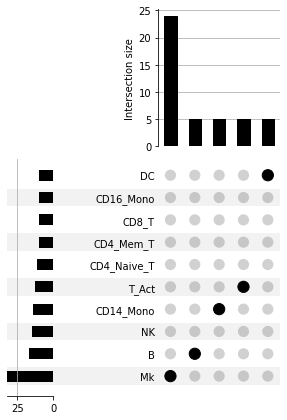

In [180]:
cell_diff = from_contents(top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()


In [181]:

kang_diff_exp_genes = ["CXCL10", "IFIT1", "RSAD2", "IFIT3", "CCL8", "IFI6", "ISG15", "CMPK2", "CXCL11", "IFIT2", "APOBEC3A", "OAS1", "HERC5", "MX1", "OAS3", "ETV7", "IFITM3", "TNFSF13B", "CCL7", "IFI44", "PLSCR1", "IDO1", "LAG3", "GBP1", "NEXN", "MX2", "ISG20", "EPSTI1", "MT2A", "LGALS9", "IL1RN", "IFI44L", "NT5C3A", "TNFSF10", "STAT2", "APOBEC3B", "LAMP3", "IFNG", "AIM2", "SAMD9L", "DDX58"]
all_res[8].loc[kang_diff_exp_genes]

FC    log2FC  abslog2FC
gene_ids                               
CXCL10    1.437057  0.523117   0.523117
IFIT1     2.384295  1.253562   1.253562
RSAD2     3.481118  1.799551   1.799551
IFIT3     2.556080  1.353933   1.353933
CCL8      1.378299  0.462889   0.462889
IFI6      1.351804  0.434886   0.434886
ISG15     1.022868  0.032620   0.032620
CMPK2     2.443089  1.288707   1.288707
CXCL11    1.094387  0.130122   0.130122
IFIT2     1.100796  0.138546   0.138546
APOBEC3A  0.821020 -0.284510   0.284510
OAS1      1.237803  0.307781   0.307781
HERC5     1.864235  0.898584   0.898584
MX1       1.940255  0.956246   0.956246
OAS3      1.597314  0.675648   0.675648
ETV7      3.016355  1.592806   1.592806
IFITM3    2.275346  1.186086   1.186086
TNFSF13B  0.705209 -0.503878   0.503878
CCL7      1.779412  0.831400   0.831400
IFI44     1.132314  0.179274   0.179274
PLSCR1    1.032029  0.045483   0.045483
IDO1      1.198927  0.261743   0.261743
LAG3      0.986608 -0.019451   0.019451
GBP1      1.541105  0.623965   0.623965
NEXN      1.317526  0.397831   0.397831
MX2       2.130384  1.091113   1.091113
ISG20     1.039990  0.056570   0.056570
EPSTI1    2.282455  1.190587   1.190587
MT2A      1.004948  0.007121   0.007121
LGALS9    0.960003 -0.058889   0.058889
IL1RN     0.875825 -0.191286   0.191286
IFI44L    2.567293  1.360248   1.360248
NT5C3A    1.528781  0.612381   0.612381
TNFSF10   1.112267  0.153503   0.153503
STAT2     1.467878  0.553732   0.553732
APOBEC3B  1.794721  0.843760   0.843760
LAMP3     2.512182  1.328941   1.328941
IFNG      0.343419 -1.541956   1.541956
AIM2      0.871073 -0.199134   0.199134
SAMD9L    1.202507  0.266046   0.266046
DDX58     1.764588  0.819332   0.819332

In [182]:
a = all_res[8]
a = a.sort_values(by=['log2FC'], ascending=False)
a.iloc[0:41]

FC    log2FC  abslog2FC
gene_ids                                 
COL23A1     7.372388  2.882132   2.882132
ARHGAP44    6.960223  2.799134   2.799134
CTIF        5.253369  2.393243   2.393243
CHEK2       5.177416  2.372232   2.372232
PPAN        5.007827  2.324185   2.324185
YWHAE       4.973095  2.314144   2.314144
PPP1R13L    4.880960  2.287165   2.287165
POLE        4.695580  2.231303   2.231303
RRM2B       4.598424  2.201139   2.201139
FCRL1       4.410750  2.141024   2.141024
MYOF        4.261071  2.091216   2.091216
LIMK2       4.197980  2.069695   2.069695
C19orf54    4.144640  2.051247   2.051247
DENND6B     4.090667  2.032336   2.032336
SGMS2       4.036322  2.013041   2.013041
SMARCC2     3.990102  1.996426   1.996426
ZNF257      3.980173  1.992831   1.992831
PIM3        3.979034  1.992418   1.992418
KIAA0825    3.944604  1.979880   1.979880
AC092295.7  3.899050  1.963123   1.963123
MKNK2       3.894562  1.961461   1.961461
ATXN7L2     3.843385  1.942377   1.942377
LRRC29      3.811978  1.930540   1.930540
PLOD3       3.794418  1.923879   1.923879
ALKBH1      3.779636  1.918247   1.918247
PRC1        3.763761  1.912175   1.912175
NEU1        3.734070  1.900749   1.900749
MS4A6A      3.647963  1.867091   1.867091
DDHD1       3.643709  1.865408   1.865408
ZBTB26      3.628771  1.859481   1.859481
TCEANC2     3.623919  1.857551   1.857551
PPIF        3.596753  1.846695   1.846695
NEK9        3.569274  1.835631   1.835631
LMO4        3.556764  1.830565   1.830565
PHLDA1      3.554651  1.829708   1.829708
TRAPPC2P1   3.514246  1.813215   1.813215
TMEM183A    3.509138  1.811117   1.811117
MUC12       3.506910  1.810200   1.810200
STK24       3.496839  1.806051   1.806051
AVP         3.484468  1.800938   1.800938
RSAD2       3.481118  1.799551   1.799551

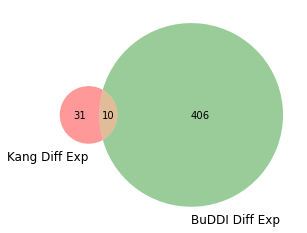

In [183]:
kang_diff_exp_genes = ["CXCL10", "IFIT1", "RSAD2", "IFIT3", "CCL8", "IFI6", "ISG15", "CMPK2", "CXCL11", "IFIT2", "APOBEC3A", "OAS1", "HERC5", "MX1", "OAS3", "ETV7", "IFITM3", "TNFSF13B", "CCL7", "IFI44", "PLSCR1", "IDO1", "LAG3", "GBP1", "NEXN", "MX2", "ISG20", "EPSTI1", "MT2A", "LGALS9", "IL1RN", "IFI44L", "NT5C3A", "TNFSF10", "STAT2", "APOBEC3B", "LAMP3", "IFNG", "AIM2", "SAMD9L", "DDX58"]

a = all_res[8]
a = a.sort_values(by=['log2FC'], ascending=False)
a.iloc[0:41]


venn2([set(kang_diff_exp_genes), set(a.iloc[np.where(a.log2FC > FC_limit)].index)], set_labels = ('Kang Diff Exp', 'BuDDI Diff Exp'))
plt.show()

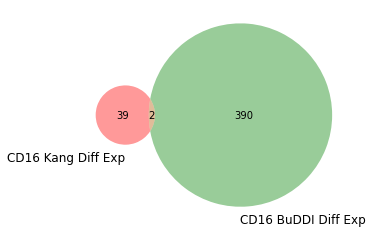

In [184]:
kang_CD16_diff_exp_genes = ["CXCL11", "CCL8", "IL27", "IFIT1", "DEFB1", "HESX1", "ISG15", "RSAD2", "CH25H", "TGM1", "NUPR1", "IDO1", "CD38", "GMPR", "IFIT2", "BCL2L14", "CXCL10", "IFIT3", "CCNA1", "HES4", "PRR5", "CMPK2", "HRASLS2", "MX1", "HERC5", "NT5C3A", "OASL", "ISG20", "SCIN", "APOBEC3A", "MX2", "SAMD4A", "SIGLEC1", "LAG3", "NEXN", "ZBP1", "PNPT1", "SLC38A5", "DHX58", "DDX58", "CACNA1A"]
a = all_res[5]
a = a.sort_values(by=['log2FC'], ascending=False)

venn2([set(kang_CD16_diff_exp_genes), set(a.iloc[np.where(a.log2FC > FC_limit)].index)], set_labels = ('CD16 Kang Diff Exp', 'CD16 BuDDI Diff Exp'))
plt.show()

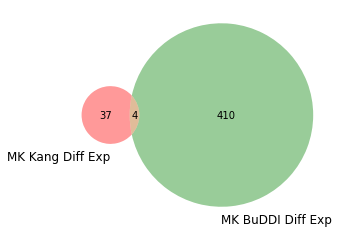

In [185]:
kang_MK_diff_exp_genes = ["RSAD2", "CXCL10", "CCL8", "IFIT3", "MX1", "IDO1", "TREX1", "IFI6", "ISG15", "IFIT1", "CXCL11", "OAS3", "EPSTI1", "TNFSF10", "MT2A", "DDX58", "MX2", "CMPK2", "SPATS2L", "LY6E", "IFI44L", "IL1RN", "SAMD9L", "TRIM22", "TARBP1", "HAPLN3", "EIF2AK2", "IFITM3", "ISG20", "HERC5", "IFI44", "OAS1", "PARP14", "OASL", "APOBEC3A", "IFIH1", "PNPT1", "HELZ2", "PLSCR1", "IFIT2", "HERC6"]

a = all_res[7]
a = a.sort_values(by=['log2FC'], ascending=False)

venn2([set(kang_MK_diff_exp_genes), set(a.iloc[np.where(a.log2FC > FC_limit)].index)], set_labels = ('MK Kang Diff Exp', 'MK BuDDI Diff Exp'))
plt.show()



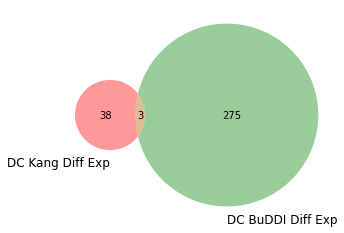

In [186]:
kang_DC_diff_exp_genes = ["IFIT1", "IFIT3", "IFIT2", "TNFSF10", "CXCL10", "CXCL11", "RSAD2", "CMPK2", "CCL8", "ISG15", "APOBEC3A", "ANKRD22", "OASL", "HERC6", "IL1RN", "DDX58", "IFI27", "OAS2", "HERC5", "LAG3", "IFITM3", "OAS1", "HES4", "CD38", "DHX58", "OAS3", "MX1", "IFI6", "TGM1", "ETV7", "IFI44L", "PDGFRL", "SLC38A5", "HESX1", "NT5C3A", "CXCL13", "LY6E", "APOBEC3B", "CXCL9", "GBP5", "NEXN"]


a = all_res[6]
a = a.sort_values(by=['log2FC'], ascending=False)

venn2([set(kang_DC_diff_exp_genes), set(a.iloc[np.where(a.log2FC > FC_limit)].index)], set_labels = ('DC Kang Diff Exp', 'DC BuDDI Diff Exp'))
plt.show()



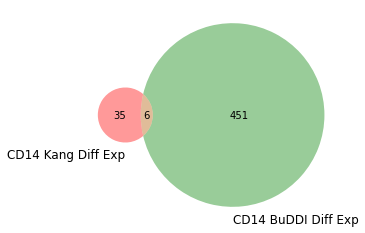

In [187]:
kang_CD14_diff_exp_genes = ["IFITM2", "SSB", "NT5C3A", "IL1RN", "RABGAP1L", "DDX58", "RTCB", "DYNLT1", "ISG20", "PSMA4", "TMEM50A", "CMPK2", "PLSCR1", "OASL", "EIF2AK2", "NAPA", "NMI", "IRF7", "TMSB10", "DRAP1", "SAMD9", "GBP4", "SP110", "SAMD9L", "IFIH1", "DEFB1", "HERC5", "IL27", "NADK", "SNX10", "MT2A", "SERPING1", "ATG3", "BLVRA", "IFI16", "SOCS1", "SPATS2L", "TMEM123", "RTP4", "PARP9", "CD38"]

a = all_res[4]

venn2([set(kang_DC_diff_exp_genes), set(a.iloc[np.where(a.log2FC > FC_limit)].index)], set_labels = ('CD14 Kang Diff Exp', 'CD14 BuDDI Diff Exp'))
plt.show()



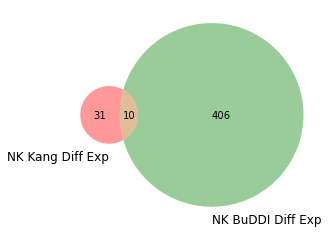

In [188]:
kang_NK_diff_exp_genes = ["CXCL10", "IFIT1", "RSAD2", "IFIT3", "CCL8", "IFI6", "ISG15", "CMPK2", "CXCL11", "IFIT2", "APOBEC3A", "OAS1", "HERC5", "MX1", "OAS3", "ETV7", "IFITM3", "TNFSF13B", "CCL7", "IFI44", "PLSCR1", "IDO1", "LAG3", "GBP1", "NEXN", "MX2", "ISG20", "EPSTI1", "MT2A", "LGALS9", "IL1RN", "IFI44L", "NT5C3A", "TNFSF10", "STAT2", "APOBEC3B", "LAMP3", "IFNG", "AIM2", "SAMD9L", "DDX58"]

a = all_res[8]
a = a.sort_values(by=['abslog2FC'], ascending=False)
a.iloc[0:41]


venn2([set(kang_NK_diff_exp_genes), set(a.iloc[np.where(a.log2FC > FC_limit)].index)], set_labels = ('NK Kang Diff Exp', 'NK BuDDI Diff Exp'))
plt.show()

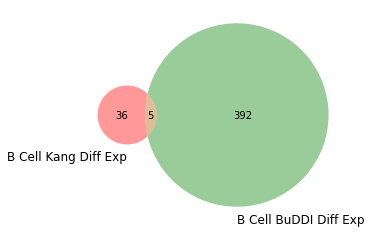

In [189]:
kang_B_diff_exp_genes = ["ISG15", "ISG20", "IFIT3", "LY6E", "IFIT1", "TNFSF10", "IFIT2", "IRF7", "UBE2L6", "IFI35", "PLSCR1", "MYL12A", "PSMB9", "NT5C3A", "EIF2AK2", "OAS1", "EPSTI1", "DYNLT1", "HERC5", "IFITM2", "SP110", "PSMA2", "GBP1", "SAMD9L", "PPM1K", "TRIM22", "SAMD9", "SOCS1", "MX2", "XAF1", "BST2", "DDX58", "OASL", "CXCL10", "TMSB10", "SAT1", "LAP3", "PSME2", "DRAP1", "IFI16", "HLA-E"]
a = all_res[0]
a = a.sort_values(by=['abslog2FC'], ascending=False)
a.iloc[0:41]


venn2([set(kang_B_diff_exp_genes), set(a.iloc[np.where(a.log2FC > FC_limit)].index)], set_labels = ('B Cell Kang Diff Exp', 'B Cell BuDDI Diff Exp'))
plt.show()